In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import string
import time

from datetime import datetime
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import ( 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, PowerTransformer
from unidecode import unidecode
from xgboost.sklearn import XGBRegressor

# Data Collection

## Downloading data

In [2]:
# python download_data.py

## Combining data from all chunks into one file

In [3]:
# cat data/offers_data*.txt | grep -v '"error"' > data/offers_data.txt

# Data Cleaning & Preparation

In [4]:
pd.set_option('display.max_columns', None)

## Loading and reviewing data

In [5]:
df = pd.read_json('data/offers_data.txt', lines=True)

In [6]:
df.head()

street                           equipment  \
0  ul. Jednosci Narodowej                                None   
1           ul. Zwycieska                                None   
2                    None                                None   
3                    None                                None   
4                    None  dishwasher, furniture, oven, stove   

                                  areas         floor   kitchen  parking  \
0                     balcony, basement       FLOOR_4      None      NaN   
1                              basement       FLOOR_1      None      NaN   
2                       balcony, garage       FLOOR_1      None      NaN   
3                      basement, garage       FLOOR_1  SEPARATE      NaN   
4  garage, garden, terrace, usable_room  GROUND_FLOOR  SEPARATE      NaN   

   numberOfRooms  rooms       type  windowsOrientation    year material  \
0              2    NaN   TENEMENT                 NaN  1920.0    BRICK   
1              1    NaN  APARTMENT                 NaN     NaN     None   
2              2    NaN       None                 NaN  2018.0     None   
3              2    NaN   TENEMENT                 NaN  1930.0    BRICK   
4              3    NaN  APARTMENT                 NaN  2022.0     None   

   windows heating  numberOfFloors    conveniences  \
0  PLASTIC     GAS             5.0            None   
1   WOODEN    None             2.0        INTERNET   
2  PLASTIC    None             2.0        INTERNET   
3     None   URBAN             4.0            None   
4  PLASTIC   URBAN             2.0  LIFT, INTERNET   

                         security      condition       ownership   rent  \
0                      ENTRYPHONE           None  FULL_OWNERSHIP  500.0   
1  ALARM, CLOSED_AREA, ENTRYPHONE           None            None  400.0   
2               ALARM, ENTRYPHONE           None            None  420.0   
3                      ENTRYPHONE  TO_COMPLETION  FULL_OWNERSHIP    NaN   
4     ENTRYPHONE, ROLLER_SHUTTERS   READY_TO_USE  FULL_OWNERSHIP  400.0   

  rent_currency        lat       long  ad_price price_currency city_name  \
0           PLN  51.123858  17.044852  675000.0            PLN   wroclaw   
1           PLN  51.058310  17.009300  380000.0            PLN   wroclaw   
2           PLN  51.142039  17.139340  532000.0            PLN   wroclaw   
3          None  51.104047  17.022767  990000.0            PLN   wroclaw   
4           PLN  51.170910  16.996370  760000.0            PLN   wroclaw   

      market   region_name    subregion_id   area  \
0  secondary  dolnoslaskie  powiat-wroclaw  68.02   
1  secondary  dolnoslaskie  powiat-wroclaw  30.00   
2  secondary  dolnoslaskie  powiat-wroclaw  38.30   
3  secondary  dolnoslaskie  powiat-wroclaw  97.00   
4    primary  dolnoslaskie  powiat-wroclaw  76.50   

                         media_types  propertype user_type offertype  \
0                               None  mieszkanie    agency  sprzedaz   
1  cable-television, internet, phone  mieszkanie    agency  sprzedaz   
2  cable-television, internet, phone  mieszkanie    agency  sprzedaz   
3                               None  mieszkanie    agency  sprzedaz   
4                           internet  mieszkanie   private  sprzedaz   

  free_from lift  
0      None    n  
1      None    n  
2      None    n  
3      None    n  
4      None    y

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91712 entries, 0 to 91711
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              54322 non-null  object 
 1   equipment           27034 non-null  object 
 2   areas               79487 non-null  object 
 3   floor               89648 non-null  object 
 4   kitchen             17296 non-null  object 
 5   parking             0 non-null      float64
 6   numberOfRooms       91712 non-null  int64  
 7   rooms               0 non-null      float64
 8   type                72648 non-null  object 
 9   windowsOrientation  0 non-null      float64
 10  year                67677 non-null  float64
 11  material            44438 non-null  object 
 12  windows             54138 non-null  object 
 13  heating             65621 non-null  object 
 14  numberOfFloors      83861 non-null  float64
 15  conveniences        58185 non-null  object 
 16  secu

In [8]:
df.isnull().mean().sort_values(ascending=False)

parking               1.000000
rooms                 1.000000
windowsOrientation    1.000000
free_from             0.854915
kitchen               0.811410
equipment             0.705229
rent_currency         0.603138
rent                  0.603138
media_types           0.573349
material              0.515461
security              0.443999
windows               0.409696
street                0.407689
conveniences          0.365568
heating               0.284488
year                  0.262070
ownership             0.241604
condition             0.233001
type                  0.207868
areas                 0.133298
numberOfFloors        0.085605
lift                  0.079870
ad_price              0.053232
floor                 0.022505
long                  0.000000
price_currency        0.000000
city_name             0.000000
lat                   0.000000
region_name           0.000000
subregion_id          0.000000
area                  0.000000
propertype            0.000000
user_typ

- renaming columns

In [9]:
df.rename(columns={
    'numberOfRooms': 'number_of_rooms',
    'numberOfFloors': 'number_of_floors',
    'type': 'building_type',
    'windowsOrientation': 'windows_orientation'
}, inplace=True)

## Imputing missing values

### equipment, areas, conveniences, security, media_types

**Analysis:**
- columns with list-like comma-separated string values

**Decision:**
- create separate column for each unique characteristic
- treat null values as lacking of specific characteristic

In [10]:
multiple_values_columns = ['equipment', 'areas', 'conveniences', 'security', 'media_types']
for column in multiple_values_columns:
    types = df[column].dropna().apply(lambda x: x.split(', ') if x else None).explode().unique()
    for t in types:
        df[t] = df[column].apply(lambda x: 1 if x is not None and t in x else 0)
df = df.drop(columns=multiple_values_columns)

- removing duplicated column added above if similar column already exists
- comparing old and newly created columns is done first in order to verify if any discrepancies are present

In [11]:
(df['INTERNET'] == df['internet']).all()

True

In [12]:
df = df.drop(columns=['internet'])

In [13]:
df.loc[df['lift'].isnull(), 'lift'] = df['LIFT']
df['lift'].replace({'y': 1, 'n': 0}, inplace=True)
(df['LIFT'] == df['lift']).all()

True

In [14]:
df = df.drop(columns=['lift'])

### kitchen

In [15]:
df.kitchen.unique()

array([None, 'SEPARATE'], dtype=object)

**Analysis:**
- only one unique value is present: SEPERATE

**Decision:**
- create separate_kitchen column with values:
  - 0 - non-separate
  - 1 - separate 
- treat null values as 0 - non-separate &emsp; <font color='orange'># consider different imputation method

In [16]:
df['separate_kitchen'] = df.kitchen.map(lambda k: 1 if k else 0)
df = df.drop(columns=['kitchen'])

### heating

In [17]:
building_type_grp = df.groupby(['building_type'])
building_type_grp['heating'].value_counts(normalize=True, dropna=False)

building_type  heating    
APARTMENT      URBAN          0.593849
               NaN            0.192092
               GAS            0.119733
               OTHER          0.057591
               BOILER_ROOM    0.022920
               ELECTRICAL     0.013710
               TILED_STOVE    0.000106
BLOCK          URBAN          0.683341
               NaN            0.153093
               GAS            0.096691
               OTHER          0.039627
               BOILER_ROOM    0.018784
               ELECTRICAL     0.007397
               TILED_STOVE    0.001068
DETACHED       NaN            1.000000
HOUSE          GAS            0.436898
               NaN            0.192093
               OTHER          0.170299
               URBAN          0.092752
               BOILER_ROOM    0.052205
               ELECTRICAL     0.045616
               TILED_STOVE    0.010137
INFILL         URBAN          0.855263
               GAS            0.078947
               BOILER_ROOM    0.03947

**Analysis:**
- 28% of values are null
- different building types generally exhibit a preference for specific heating types over others

**Decision**: 
- fillna using the mode value associated with each building type
- if obtaining the mode value for a specific building type is not possible, use the mode value corresponding to the entire dataset

In [18]:
for building_type in df.building_type.dropna().unique():
    heating_mode = df[df['building_type'] == building_type]['heating'].mode()
    heating_mode = heating_mode[0] if heating_mode.any() else df['heating'].mode()[0]
    df.loc[df['building_type'] == building_type, 'heating'] = df['heating'].fillna(heating_mode)

### windows, ownership

In [19]:
df.windows.value_counts(normalize=True, dropna=False)

windows
PLASTIC      0.543342
None         0.409696
WOODEN       0.038523
ALUMINIUM    0.008439
Name: proportion, dtype: float64

In [20]:
df.ownership.value_counts(normalize=True, dropna=False)

ownership
FULL_OWNERSHIP            0.719622
None                      0.241604
LIMITED_OWNERSHIP         0.035088
SHARE                     0.003053
USUFRUCT                  0.000622
CO_OPERATIVE_OWNERSHIP    0.000011
Name: proportion, dtype: float64

**Analysis:**
- one value significantly dominates

**Decision:** 
- fillna using the mode value corresponding to the entire dataset

In [21]:
df.windows.fillna(df.windows.mode()[0], inplace=True)
df.ownership.fillna(df.ownership.mode()[0], inplace=True)

In [22]:
df.isnull().mean().sort_values(ascending=False)

parking                1.000000
rooms                  1.000000
windows_orientation    1.000000
free_from              0.854915
rent                   0.603138
rent_currency          0.603138
material               0.515461
street                 0.407689
year                   0.262070
condition              0.233001
building_type          0.207868
heating                0.152052
number_of_floors       0.085605
ad_price               0.053232
floor                  0.022505
sewage                 0.000000
water                  0.000000
garage                 0.000000
garden                 0.000000
terrace                0.000000
usable_room            0.000000
INTERNET               0.000000
gas                    0.000000
LIFT                   0.000000
ENTRYPHONE             0.000000
ALARM                  0.000000
CLOSED_AREA            0.000000
ROLLER_SHUTTERS        0.000000
ANTI_BURGLARY_DOOR     0.000000
MONITORING             0.000000
cable-television       0.000000
phone   

### parking, rooms, windows_orientation, free_from, rent, rent_currency, material, street, year, condition, building_type, number_of_floors, ad_price, floor 

**Analysis:**
- no resonable methods of imputation where identified &emsp; <font color='orange'># think about imputation method for condition and building_type features

## Cleaning data

In [23]:
df.head()

street         floor  parking  number_of_rooms  rooms  \
0  ul. Jednosci Narodowej       FLOOR_4      NaN                2    NaN   
1           ul. Zwycieska       FLOOR_1      NaN                1    NaN   
2                    None       FLOOR_1      NaN                2    NaN   
3                    None       FLOOR_1      NaN                2    NaN   
4                    None  GROUND_FLOOR      NaN                3    NaN   

  building_type  windows_orientation    year material  windows heating  \
0      TENEMENT                  NaN  1920.0    BRICK  PLASTIC     GAS   
1     APARTMENT                  NaN     NaN     None   WOODEN   URBAN   
2          None                  NaN  2018.0     None  PLASTIC    None   
3      TENEMENT                  NaN  1930.0    BRICK  PLASTIC   URBAN   
4     APARTMENT                  NaN  2022.0     None  PLASTIC   URBAN   

   number_of_floors      condition       ownership   rent rent_currency  \
0               5.0           None  FULL_OWNERSHIP  500.0           PLN   
1               2.0           None  FULL_OWNERSHIP  400.0           PLN   
2               2.0           None  FULL_OWNERSHIP  420.0           PLN   
3               4.0  TO_COMPLETION  FULL_OWNERSHIP    NaN          None   
4               2.0   READY_TO_USE  FULL_OWNERSHIP  400.0           PLN   

         lat       long  ad_price price_currency city_name     market  \
0  51.123858  17.044852  675000.0            PLN   wroclaw  secondary   
1  51.058310  17.009300  380000.0            PLN   wroclaw  secondary   
2  51.142039  17.139340  532000.0            PLN   wroclaw  secondary   
3  51.104047  17.022767  990000.0            PLN   wroclaw  secondary   
4  51.170910  16.996370  760000.0            PLN   wroclaw    primary   

    region_name    subregion_id   area  propertype user_type offertype  \
0  dolnoslaskie  powiat-wroclaw  68.02  mieszkanie    agency  sprzedaz   
1  dolnoslaskie  powiat-wroclaw  30.00  mieszkanie    agency  sprzedaz   
2  dolnoslaskie  powiat-wroclaw  38.30  mieszkanie    agency  sprzedaz   
3  dolnoslaskie  powiat-wroclaw  97.00  mieszkanie    agency  sprzedaz   
4  dolnoslaskie  powiat-wroclaw  76.50  mieszkanie   private  sprzedaz   

  free_from  dishwasher  furniture  oven  stove  fridge  washing_machine  \
0      None           0          0     0      0       0                0   
1      None           0          0     0      0       0                0   
2      None           0          0     0      0       0                0   
3      None           0          0     0      0       0                0   
4      None           1          1     1      1       0                0   

   air_conditioning  tv  balcony  basement  garage  garden  terrace  \
0                 0   0        1         1       0       0        0   
1                 0   0        0         1       0       0        0   
2                 0   0        1         0       1       0        0   
3                 0   0        0         1       1       0        0   
4                 0   0        0         0       1       1        1   

   usable_room  INTERNET  LIFT  ENTRYPHONE  ALARM  CLOSED_AREA  \
0            0         0     0           1      0            0   
1            0         1     0           1      1            1   
2            0         1     0           1      1            0   
3            0         0     0           1      0            0   
4            1         1     1           1      0            0   

   ROLLER_SHUTTERS  ANTI_BURGLARY_DOOR  MONITORING  cable-television  phone  \
0                0                   0           0                 0      0   
1                0                   0           0                 1      1   
2                0                   0           0                 1      1   
3                0                   0           0                 0      0   
4                1                   0           0                 0      0   

   cable_television  elect

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91712 entries, 0 to 91711
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   street               54322 non-null  object 
 1   floor                89648 non-null  object 
 2   parking              0 non-null      float64
 3   number_of_rooms      91712 non-null  int64  
 4   rooms                0 non-null      float64
 5   building_type        72648 non-null  object 
 6   windows_orientation  0 non-null      float64
 7   year                 67677 non-null  float64
 8   material             44438 non-null  object 
 9   windows              91712 non-null  object 
 10  heating              77767 non-null  object 
 11  number_of_floors     83861 non-null  float64
 12  condition            70343 non-null  object 
 13  ownership            91712 non-null  object 
 14  rent                 36397 non-null  float64
 15  rent_currency        36397 non-null 

In [25]:
df.isnull().mean().sort_values(ascending=False)

parking                1.000000
rooms                  1.000000
windows_orientation    1.000000
free_from              0.854915
rent                   0.603138
rent_currency          0.603138
material               0.515461
street                 0.407689
year                   0.262070
condition              0.233001
building_type          0.207868
heating                0.152052
number_of_floors       0.085605
ad_price               0.053232
floor                  0.022505
sewage                 0.000000
water                  0.000000
garage                 0.000000
garden                 0.000000
terrace                0.000000
usable_room            0.000000
INTERNET               0.000000
gas                    0.000000
LIFT                   0.000000
ENTRYPHONE             0.000000
ALARM                  0.000000
CLOSED_AREA            0.000000
ROLLER_SHUTTERS        0.000000
ANTI_BURGLARY_DOOR     0.000000
MONITORING             0.000000
cable-television       0.000000
phone   

In [26]:
unique_counts = df.nunique()
columns_with_one_unique_value = unique_counts[unique_counts == 1].index.tolist()
columns_with_one_unique_value

['propertype', 'offertype']

##### Analysis:
- parking, rooms, windows_orientation, free_from, rent, rent_currency, material, street - over 40% of null values
- propertype, offertype - only one unique value
- year, condition, building_type, heating - less than 30% of null values
- number_of_floors, ad_price, floor - less than 1% of null values
##### Decision:
- parking, rooms, windows_orientation, free_from, rent, rent_currency, material, street, propertype, offertype - drop entire columns
- year, condition, building_type, heating, number_of_floors, ad_price, floor - dropna

In [27]:
df = df.drop(columns=['parking', 'rooms', 'windows_orientation', 'free_from', 'rent', 'rent_currency', 'material', 'street', 'propertype', 'offertype'])

In [28]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41473 entries, 0 to 41472
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               41473 non-null  object 
 1   number_of_rooms     41473 non-null  int64  
 2   building_type       41473 non-null  object 
 3   year                41473 non-null  float64
 4   windows             41473 non-null  object 
 5   heating             41473 non-null  object 
 6   number_of_floors    41473 non-null  float64
 7   condition           41473 non-null  object 
 8   ownership           41473 non-null  object 
 9   lat                 41473 non-null  float64
 10  long                41473 non-null  float64
 11  ad_price            41473 non-null  float64
 12  price_currency      41473 non-null  object 
 13  city_name           41473 non-null  object 
 14  market              41473 non-null  object 
 15  region_name         41473 non-null  object 
 16  subr

- check unique values again after dropping na

In [30]:
unique_counts = df.nunique()
columns_with_one_unique_value = unique_counts[unique_counts == 1].index.tolist()
columns_with_one_unique_value

['cable_television', 'electricity', 'sewage', 'water', 'gas']

In [31]:
df = df.drop(columns=columns_with_one_unique_value)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41473 entries, 0 to 41472
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               41473 non-null  object 
 1   number_of_rooms     41473 non-null  int64  
 2   building_type       41473 non-null  object 
 3   year                41473 non-null  float64
 4   windows             41473 non-null  object 
 5   heating             41473 non-null  object 
 6   number_of_floors    41473 non-null  float64
 7   condition           41473 non-null  object 
 8   ownership           41473 non-null  object 
 9   lat                 41473 non-null  float64
 10  long                41473 non-null  float64
 11  ad_price            41473 non-null  float64
 12  price_currency      41473 non-null  object 
 13  city_name           41473 non-null  object 
 14  market              41473 non-null  object 
 15  region_name         41473 non-null  object 
 16  subr

# Exploratory Data Analysis

## Categorical columns

In [33]:
categorical_columns = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
categorical_columns

['floor',
 'building_type',
 'windows',
 'heating',
 'condition',
 'ownership',
 'price_currency',
 'city_name',
 'market',
 'region_name',
 'subregion_id',
 'user_type']

In [34]:
for column in df[categorical_columns].columns:
    print(df[column].value_counts(normalize=True, dropna=False))
    print('-------------------------------------')
    print(f'unique values: {df[column].nunique()}')
    print(df[column].unique())
    print('\n=====================================\n')

floor
FLOOR_1            0.250259
GROUND_FLOOR       0.207340
FLOOR_2            0.189497
FLOOR_3            0.153763
FLOOR_4            0.099245
FLOOR_5            0.032503
FLOOR_6            0.019989
FLOOR_7            0.013189
FLOOR_HIGHER_10    0.010031
FLOOR_8            0.009090
FLOOR_9            0.006583
FLOOR_10           0.006076
GARRET             0.001736
CELLAR             0.000699
Name: proportion, dtype: float64
-------------------------------------
unique values: 14
['FLOOR_1' 'GROUND_FLOOR' 'FLOOR_10' 'FLOOR_2' 'FLOOR_3' 'FLOOR_4'
 'FLOOR_5' 'FLOOR_6' 'FLOOR_HIGHER_10' 'FLOOR_8' 'FLOOR_7' 'FLOOR_9'
 'GARRET' 'CELLAR']


building_type
BLOCK        0.546283
APARTMENT    0.279965
TENEMENT     0.115545
RIBBON       0.030839
HOUSE        0.024691
INFILL       0.001350
LOFT         0.001326
Name: proportion, dtype: float64
-------------------------------------
unique values: 7
['TENEMENT' 'APARTMENT' 'BLOCK' 'RIBBON' 'HOUSE' 'INFILL' 'LOFT']


windows
PLASTIC      0.939864
W

### city_name

In [35]:
df.city_name.nunique()

1444

In [36]:
punctuation_chars = set(string.punctuation)
whitespace_chars = set(string.whitespace)
special_chars = punctuation_chars - {'-'} | whitespace_chars

df[df['city_name'].apply(lambda x: any(map(lambda y: y in x, special_chars)))]['city_name'].head()

2     boleslawiec_1180
3     boleslawiec_1180
24    boleslawiec_1180
51       olesnica_1705
54        sadkow_21010
Name: city_name, dtype: object

In [37]:
df = df.drop(columns=['subregion_id'])  # too many unique values, information conveyed in region_name

In [38]:
df = df.drop(columns=['user_type'])  # irrelevant, since we want to assess the value of the property

## Numerical columns

In [39]:
df.describe()

number_of_rooms          year  number_of_floors           lat  \
count     41473.000000  41473.000000      41473.000000  41473.000000   
mean          2.701710   1999.034191          4.345767     52.106792   
std           0.992677     36.008011         10.382467      1.478337   
min           0.000000   1056.000000          1.000000     49.267410   
25%           2.000000   1980.000000          3.000000     50.916110   
50%           3.000000   2018.000000          4.000000     52.183826   
75%           3.000000   2023.000000          5.000000     53.395563   
max          10.000000   3022.000000       2019.000000     54.833130   

               long      ad_price          area    dishwasher     furniture  \
count  41473.000000  4.147300e+04  4.147300e+04  41473.000000  41473.000000   
mean      18.797418  6.830425e+05  1.475944e+02      0.160683      0.318279   
std        2.172595  6.003399e+05  1.758112e+04      0.367243      0.465814   
min       14.225321  2.965200e+04  1.000000e+00      0.000000      0.000000   
25%       17.023994  3.989810e+05  4.363000e+01      0.000000      0.000000   
50%       18.824302  5.580020e+05  5.558000e+01      0.000000      0.000000   
75%       20.797046  7.788000e+05  7.003000e+01      0.000000      1.000000   
max       23.938380  2.135010e+07  3.580432e+06      1.000000      1.000000   

               oven         stove        fridge  washing_machine  \
count  41473.000000  41473.000000  41473.000000     41473.000000   
mean       0.202614      0.218889      0.213247         0.153907   
std        0.401952      0.413498      0.409606         0.360864   
min        0.000000      0.000000      0.000000         0.000000   
25%        0.000000      0.000000      0.000000         0.000000   
50%        0.000000      0.000000      0.000000         0.000000   
75%        0.000000      0.000000      0.000000         0.000000   
max        1.000000      1.000000      1.000000         1.000000   

       air_conditioning            tv       balcony      basement  \
count      41473.000000  41473.000000  41473.000000  41473.000000   
mean           0.077424      0.075157      0.618113      0.362911   
std            0.267266      0.263648      0.485855      0.480845   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
50%            0.000000      0.000000      1.000000      0.000000   
75%            0.000000      0.000000      1.000000      1.000000   
max            1.000000      1.000000      1.000000      1.000000   

             garage        garden       terrace   usable_room      INTERNET  \
count  41473.000000  41473.000000  41473.000000  41473.000000  41473.000000   
mean       0.568948      0.140188      0.157814      0.221855      0.544209   
std        0.495229      0.347186      0.364570      0.415499      0.498048   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      1.000000   
75%        1.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               LIFT    ENTRYPHONE         ALARM   CLOSED_AREA  \
count  41473.000000  41473.000000  41473.000000  41473.000000   
mean       0.503846      0.582765      0.079883      0.230511   
std        0.499991      0.493108      0.271116      0.421165   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000   

       ROLLER_SHUTTERS  ANTI_BURGLARY_DOOR    MONITORING  cable-television  \
count     41473.000000        41473

### Data distribution

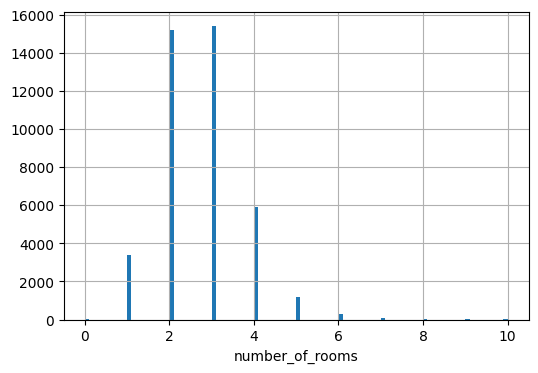

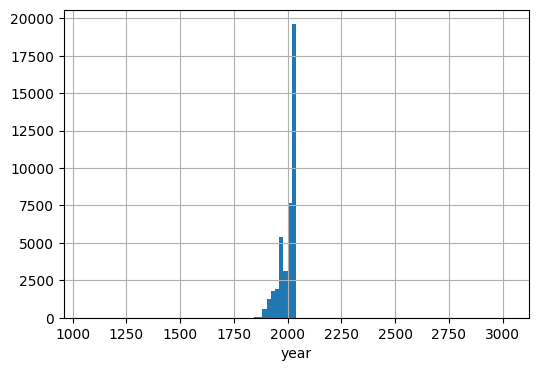

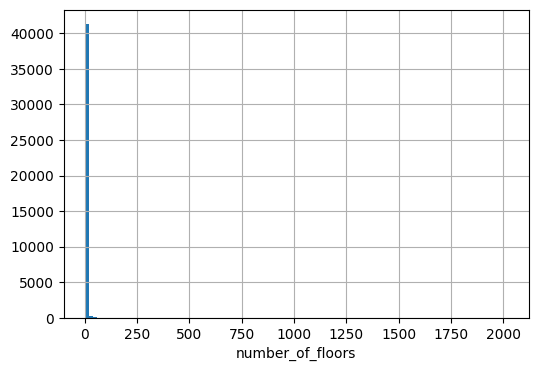

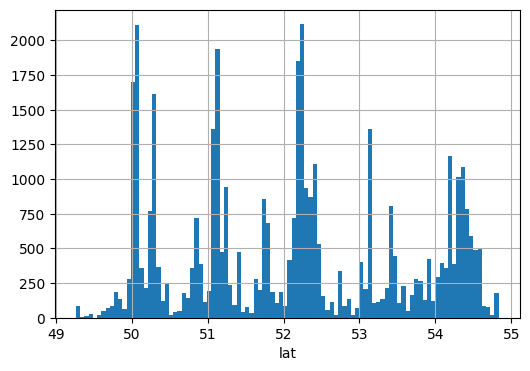

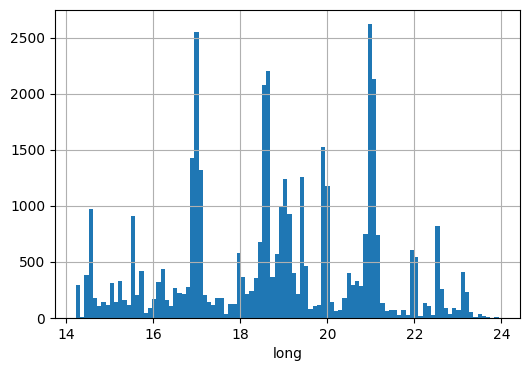

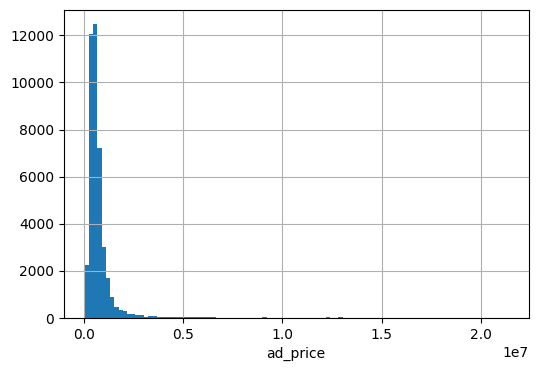

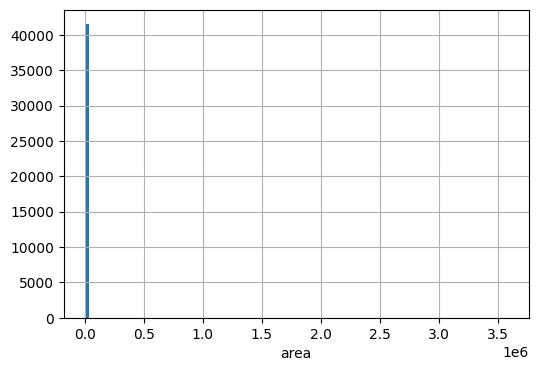

In [40]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for column in numerical_columns:
    if all(value in [0, 1] for value in df[column].unique()):
        continue
    plt.figure(figsize=(6, 4))
    plt.hist(df[column], bins=100)
    plt.xlabel(column)
    plt.grid(True)
    plt.show()

### Correlation

In [41]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

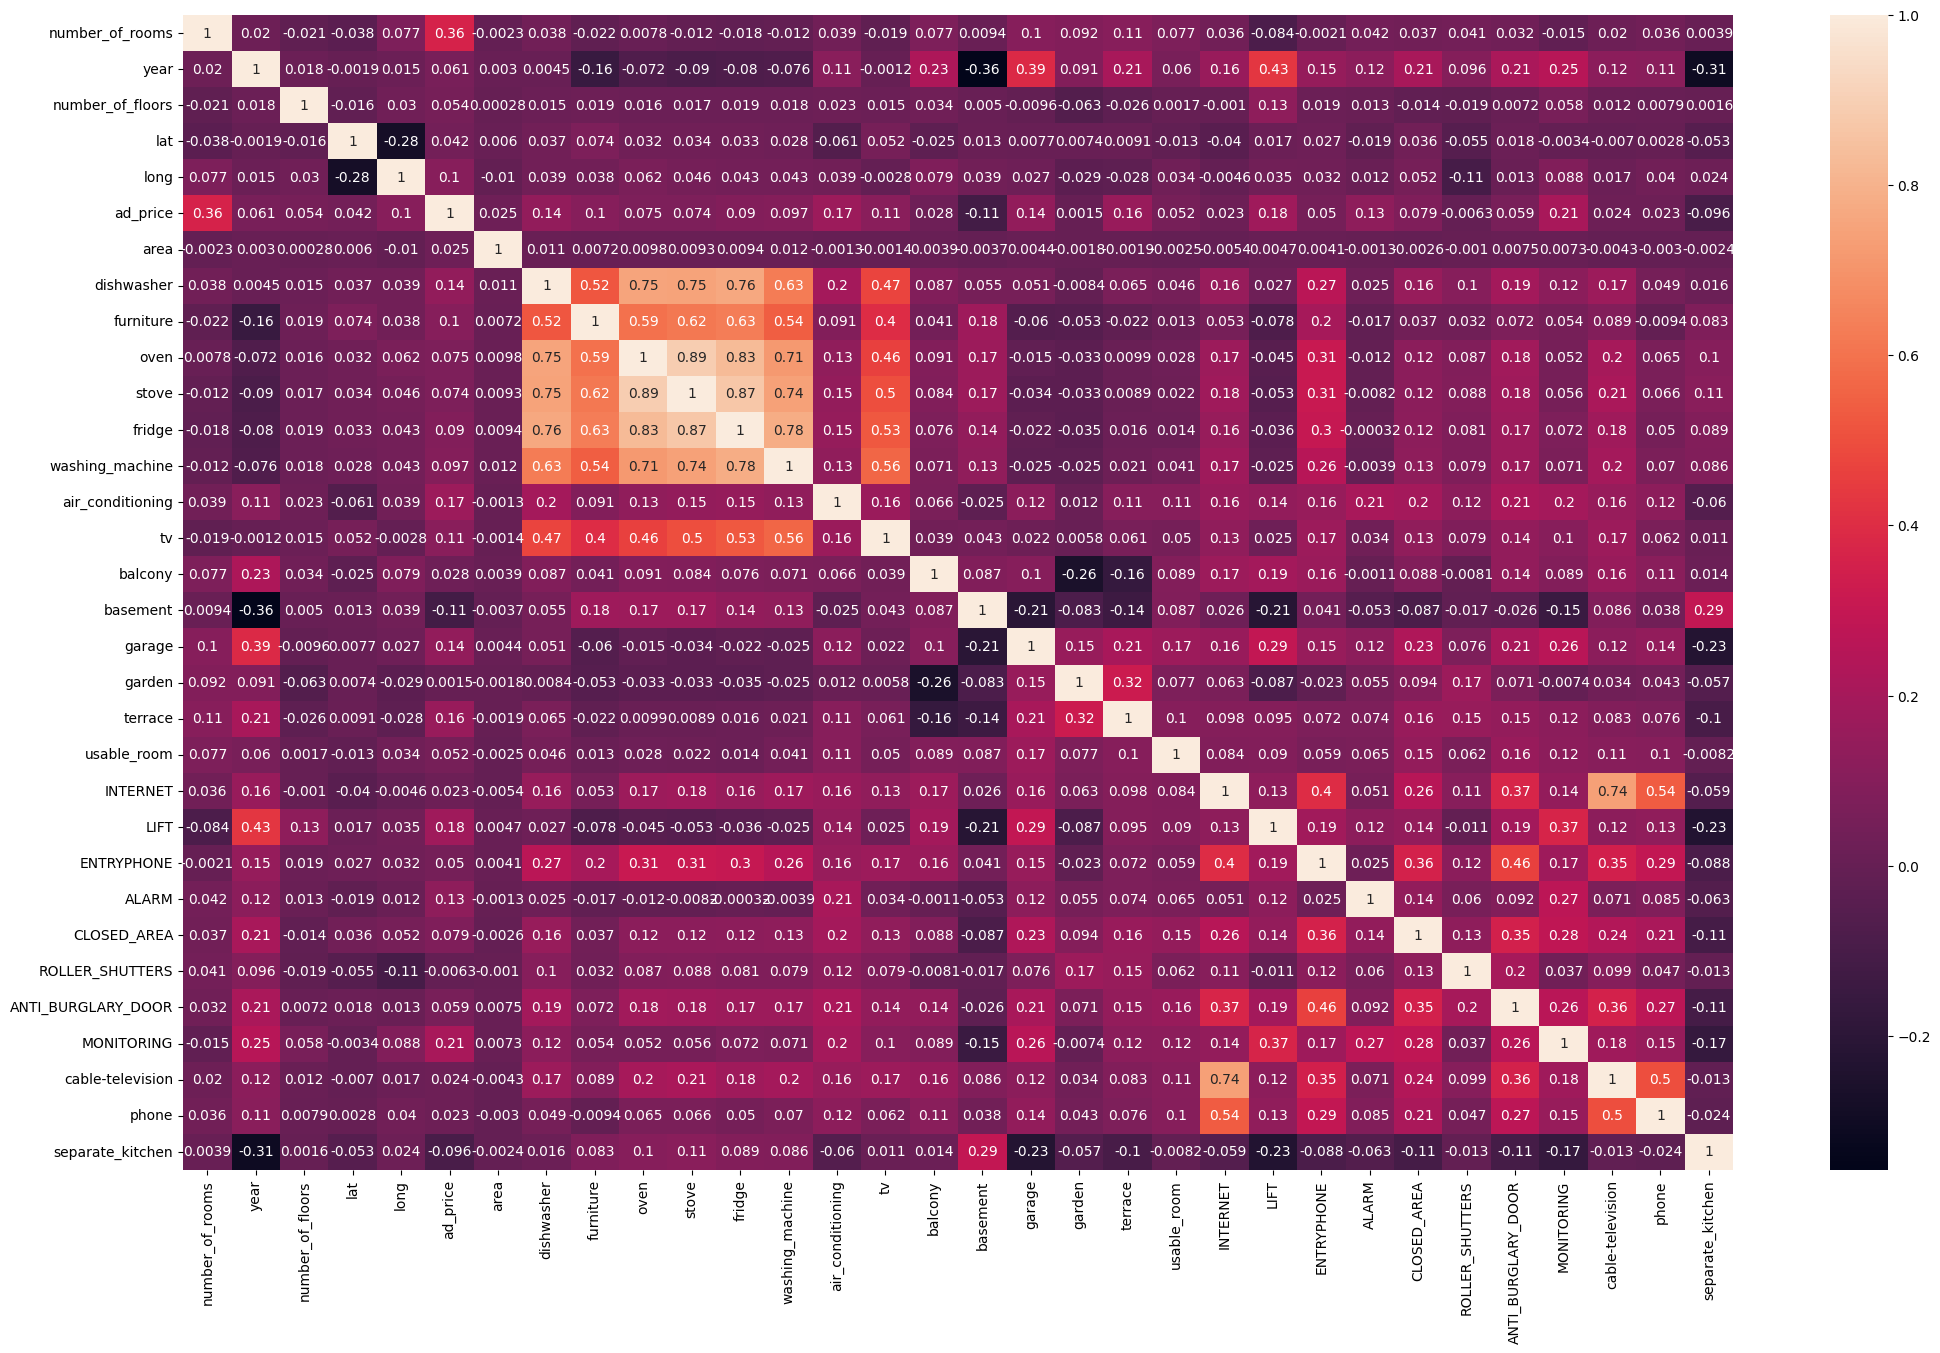

In [42]:
plt.figure(figsize=(25,15))
sns.heatmap(df[numerical_columns].corr(), annot=True);

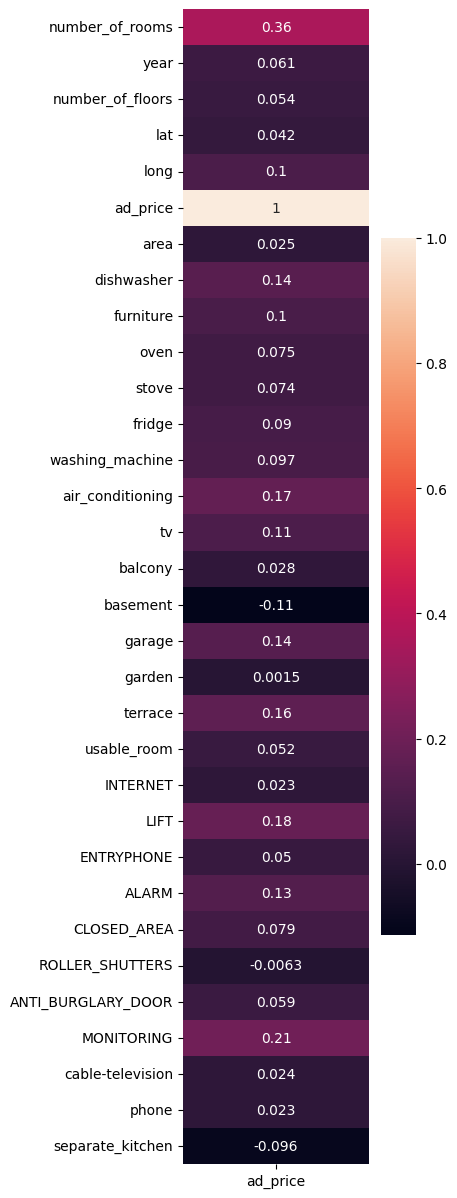

In [43]:
plt.figure(figsize=(3,15))
sns.heatmap(pd.DataFrame(df[numerical_columns].corr()['ad_price']), annot=True);

In [44]:
(x := df
 .corr(numeric_only=True)
 .abs()['ad_price']
).sort_values(ascending=False)[x > 0.5].index

Index(['ad_price'], dtype='object')

In [45]:
(x := df
 .corr(numeric_only=True)
 .abs()['ad_price']
).sort_values(ascending=False)[x > 0.15].index

Index(['ad_price', 'number_of_rooms', 'MONITORING', 'LIFT', 'air_conditioning',
       'terrace'],
      dtype='object')

# Feature Engineering

## Adjusting existing features

### floor

In [46]:
df.floor.value_counts()

floor
FLOOR_1            10379
GROUND_FLOOR        8599
FLOOR_2             7859
FLOOR_3             6377
FLOOR_4             4116
FLOOR_5             1348
FLOOR_6              829
FLOOR_7              547
FLOOR_HIGHER_10      416
FLOOR_8              377
FLOOR_9              273
FLOOR_10             252
GARRET                72
CELLAR                29
Name: count, dtype: int64

In [47]:
def process_floor(floor):
    if floor == 'CELLAR':
        return -1
    elif floor == 'GROUND_FLOOR':
        return 0
    elif floor == 'FLOOR_HIGHER_10':
        return 11
    elif floor == 'GARRET':
        return 12
    else:
        return int(floor.split('_')[-1])

In [48]:
df.floor = df.floor.apply(process_floor)

### windows

In [49]:
df.windows.value_counts(normalize=True)

windows
PLASTIC      0.939864
WOODEN       0.048296
ALUMINIUM    0.011839
Name: proportion, dtype: float64

In [50]:
df.windows = df.windows.replace(['WOODEN', 'ALUMINIUM'], 'NON_PLASTIC')

### heating

In [51]:
df.heating.value_counts(normalize=True)

heating
URBAN          0.697466
GAS            0.201119
OTHER          0.056591
BOILER_ROOM    0.022931
ELECTRICAL     0.020061
TILED_STOVE    0.001833
Name: proportion, dtype: float64

In [52]:
df.heating = df.heating.replace(['TILED_STOVE', 'ELECTRICAL', 'BOILER_ROOM'], 'OTHER')

### condition

In [53]:
df.condition.value_counts(normalize=True)

condition
READY_TO_USE     0.508114
TO_COMPLETION    0.408844
TO_RENOVATION    0.083042
Name: proportion, dtype: float64

In [54]:
df.condition = df.condition.replace('TO_RENOVATION', 'TO_COMPLETION')

### ownership

In [55]:
df.ownership.value_counts(normalize=True)

ownership
FULL_OWNERSHIP       0.953849
LIMITED_OWNERSHIP    0.041834
SHARE                0.003231
USUFRUCT             0.001085
Name: proportion, dtype: float64

In [56]:
df.ownership = df.ownership.replace(['SHARE', 'USUFRUCT'], 'LIMITED_OWNERSHIP')

### price_currency

In [57]:
df.price_currency.unique()

array(['PLN', 'EUR'], dtype=object)

In [58]:
df.loc[df['price_currency'] == 'EUR', 'ad_price'] = df['ad_price'] * 4.35
df.loc[df['price_currency'] == 'USD', 'ad_price'] = df['ad_price'] * 4
df = df.drop(columns=['price_currency'])

### city_name

In [59]:
punctuation_chars = set(string.punctuation)
whitespace_chars = set(string.whitespace)
special_chars = punctuation_chars - {'-'} | whitespace_chars

df['city_name'] = df['city_name'].apply(lambda x: '_'.join(x.split('_')[:-1]) if x.split('_')[-1].isdigit() else x)

### building_type

In [60]:
df.building_type.value_counts(normalize=True)

building_type
BLOCK        0.546283
APARTMENT    0.279965
TENEMENT     0.115545
RIBBON       0.030839
HOUSE        0.024691
INFILL       0.001350
LOFT         0.001326
Name: proportion, dtype: float64

In [61]:
df.building_type = df.building_type.replace(['INFILL', 'LOFT', 'HOUSE', 'RIBBON'], 'OTHER')

## Adding new features

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41473 entries, 0 to 41472
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               41473 non-null  int64  
 1   number_of_rooms     41473 non-null  int64  
 2   building_type       41473 non-null  object 
 3   year                41473 non-null  float64
 4   windows             41473 non-null  object 
 5   heating             41473 non-null  object 
 6   number_of_floors    41473 non-null  float64
 7   condition           41473 non-null  object 
 8   ownership           41473 non-null  object 
 9   lat                 41473 non-null  float64
 10  long                41473 non-null  float64
 11  ad_price            41473 non-null  float64
 12  city_name           41473 non-null  object 
 13  market              41473 non-null  object 
 14  region_name         41473 non-null  object 
 15  area                41473 non-null  float64
 16  dish

### building_age

In [63]:
df['building_age'] = df['year'].apply(lambda x: age if (age := datetime.now().year - x) >= 0 else 0)

### population, city_area, population_density

In [64]:
df_cities_data = pd.read_csv('data/cities_data.txt', sep=',')  # https://pl.wikipedia.org/wiki/Dane_statystyczne_o_miastach_w_Polsce

In [65]:
df_cities_data.head()

city_name    subregion_id         region_name  city_area  \
0  Aleksandrów Kujawski  aleksandrowski  kujawsko-pomorskie        723   
1    Aleksandrów Łódzki        zgierski             łódzkie       1382   
2              Alwernia     chrzanowski         małopolskie        888   
3             Andrychów       wadowicki         małopolskie       1033   
4               Annopol       kraśnicki           lubelskie        773   

   population  population_density  
0       12058                1668  
1       21754                1574  
2        3336                 376  
3       19837                1920  
4        2436                 315

In [66]:
df_cities_data['city_name'] = df_cities_data['city_name'].apply(lambda x: '-'.join(unidecode(x).lower().split()))

In [67]:
df_cities_data.head()

city_name    subregion_id         region_name  city_area  \
0  aleksandrow-kujawski  aleksandrowski  kujawsko-pomorskie        723   
1    aleksandrow-lodzki        zgierski             łódzkie       1382   
2              alwernia     chrzanowski         małopolskie        888   
3             andrychow       wadowicki         małopolskie       1033   
4               annopol       kraśnicki           lubelskie        773   

   population  population_density  
0       12058                1668  
1       21754                1574  
2        3336                 376  
3       19837                1920  
4        2436                 315

In [68]:
df[df.city_name.apply(lambda x: x not in df_cities_data.city_name.tolist())].shape[0]

3041

In [69]:
cities_names = df_cities_data.city_name.to_list()
def create_feature(city_name, feature_name):
    if not city_name in cities_names:
        return None
    else:
        return df_cities_data[df_cities_data.city_name == city_name][feature_name].iloc[0]

In [70]:
df['population'] = df.city_name.apply(create_feature, args=('population',))

In [71]:
df['city_area'] = df.city_name.apply(create_feature, args=('city_area',))

In [72]:
df['population_density'] = df.city_name.apply(create_feature, args=('population_density',))

In [73]:
df.drop(columns=['city_name'], inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Data Preprocessing

In [74]:
X = df.drop(columns=['ad_price'])
y = df['ad_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
X_train.shape, X_test.shape

((30745, 43), (7687, 43))

In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30745 entries, 11178 to 15795
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               30745 non-null  int64  
 1   number_of_rooms     30745 non-null  int64  
 2   building_type       30745 non-null  object 
 3   year                30745 non-null  float64
 4   windows             30745 non-null  object 
 5   heating             30745 non-null  object 
 6   number_of_floors    30745 non-null  float64
 7   condition           30745 non-null  object 
 8   ownership           30745 non-null  object 
 9   lat                 30745 non-null  float64
 10  long                30745 non-null  float64
 11  market              30745 non-null  object 
 12  region_name         30745 non-null  object 
 13  area                30745 non-null  float64
 14  dishwasher          30745 non-null  int64  
 15  furniture           30745 non-null  int64  
 16  oven 

## Outliers

In [77]:
from scipy.stats import zscore

def get_outliers_zscore(df, threshold=3):
    result = {}
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for column in numerical_columns:
        if all(value in [0, 1] for value in df[column].unique()):
            continue
        outliers = df[abs(zscore(df[column])) > threshold]
        num_outliers = len(outliers)
        if num_outliers:
            result.update({column: {'num': num_outliers, 'values': outliers}})
    return result

def get_outliers_iqr(df):
    result = {}
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for column in numerical_columns:
        if all(value in [0, 1] for value in df[column].unique()):
            continue
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        num_outliers = len(outliers)
        if num_outliers:
            result.update({column: {'num': num_outliers, 'values': outliers}})
    return result

def remove_outliers_iqr(df):
    outliers_columns = get_outliers_iqr(df).keys()
    df_filtered = df.copy()
    for column in outliers_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    return df_filtered

def remove_outliers_zscore(df):
    outliers_columns = get_outliers_zscore(df).keys()
    return df[(np.abs(zscore(df[outliers_columns])) < 3).all(axis=1)]

In [78]:
outliers_zscore = get_outliers_zscore(X_train)
outliers_iqr = get_outliers_iqr(X_train)

In [79]:
for k, v in outliers_zscore.items():
    print(k, v['num'])

floor 808
number_of_rooms 270
year 121
number_of_floors 19
area 1
building_age 120


In [80]:
for k, v in outliers_iqr.items():
    print(k, v['num'])

floor 1539
number_of_rooms 1178
year 1167
number_of_floors 2817
area 1633
building_age 1165
population 4004
population_density 67


In [81]:
X_train_zscore = remove_outliers_zscore(X_train)
X_train_zscore.shape[0]

29554

In [82]:
X_train_iqr = remove_outliers_iqr(X_train)
X_train_iqr.shape[0]

21852

- removing outliers &emsp; <font color='orange'># consider analyzing and removing outliers for each feature separately

In [83]:
X_train = X_train_zscore
# X_train = X_train_iqr

In [84]:
X_train.shape

(29554, 43)

## Scaling

In [85]:
X_train.describe()

floor  number_of_rooms          year  number_of_floors  \
count  29554.000000     29554.000000  29554.000000      29554.000000   
mean       2.058334         2.672532   1999.055424          4.222271   
std        1.749317         0.919579     32.814341          2.587362   
min       -1.000000         0.000000   1890.000000          1.000000   
25%        1.000000         2.000000   1980.000000          3.000000   
50%        2.000000         3.000000   2017.000000          4.000000   
75%        3.000000         3.000000   2023.000000          5.000000   
max        8.000000         5.000000   2026.000000         30.000000   

                lat          long          area    dishwasher     furniture  \
count  29554.000000  29554.000000  29554.000000  29554.000000  29554.000000   
mean      52.056934     18.873494     60.371813      0.161095      0.320972   
std        1.460213      2.147071     40.111042      0.367625      0.466858   
min       49.282100     14.225321      1.000000      0.000000      0.000000   
25%       50.887193     17.039760     43.900000      0.000000      0.000000   
50%       52.163581     18.922930     55.450000      0.000000      0.000000   
75%       53.154151     20.868791     69.700000      0.000000      1.000000   
max       54.808480     23.896709   5074.000000      1.000000      1.000000   

               oven         stove        fridge  washing_machine  \
count  29554.000000  29554.000000  29554.000000     29554.000000   
mean       0.205522      0.219327      0.213101         0.154057   
std        0.404089      0.413798      0.409506         0.361009   
min        0.000000      0.000000      0.000000         0.000000   
25%        0.000000      0.000000      0.000000         0.000000   
50%        0.000000      0.000000      0.000000         0.000000   
75%        0.000000      0.000000      0.000000         0.000000   
max        1.000000      1.000000      1.000000         1.000000   

       air_conditioning            tv       balcony      basement  \
count      29554.000000  29554.000000  29554.000000  29554.000000   
mean           0.074948      0.074034      0.624856      0.376734   
std            0.263311      0.261831      0.484168      0.484576   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
50%            0.000000      0.000000      1.000000      0.000000   
75%            0.000000      0.000000      1.000000      1.000000   
max            1.000000      1.000000      1.000000      1.000000   

             garage        garden       terrace   usable_room      INTERNET  \
count  29554.000000  29554.000000  29554.000000  29554.000000  29554.000000   
mean       0.561819      0.128511      0.151790      0.225824      0.549976   
std        0.496172      0.334663      0.358823      0.418131      0.497505   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      1.000000   
75%        1.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               LIFT    ENTRYPHONE         ALARM   CLOSED_AREA  \
count  29554.000000  29554.000000  29554.000000  29554.000000   
mean       0.510049      0.595994      0.079482      0.230020   
std        0.499907      0.490707      0.270494      0.420852   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000   

       ROLLER_SHUTTERS  ANTI_BURGLARY_DOOR    MONITORING  cable-television  \
count     29554.000000        29554.000000

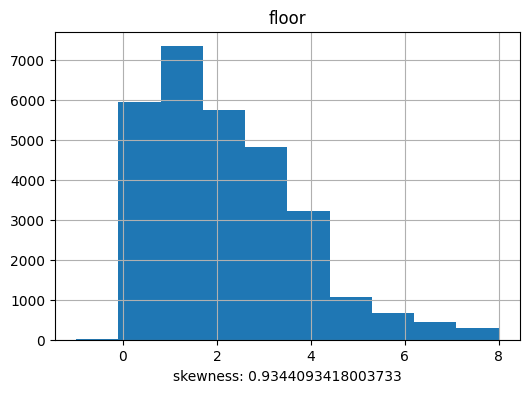

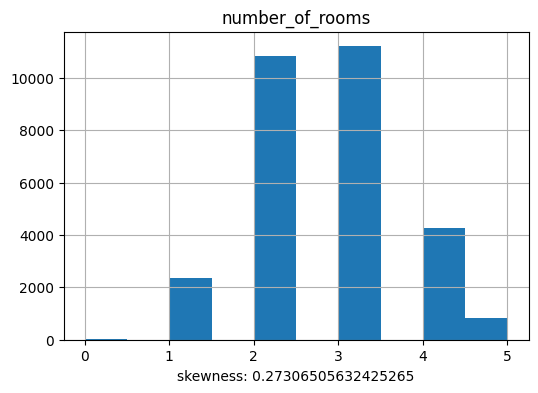

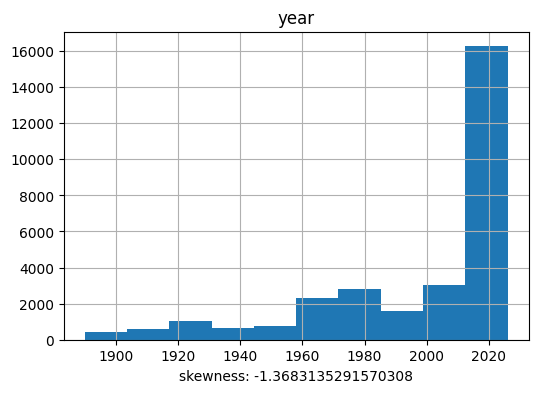

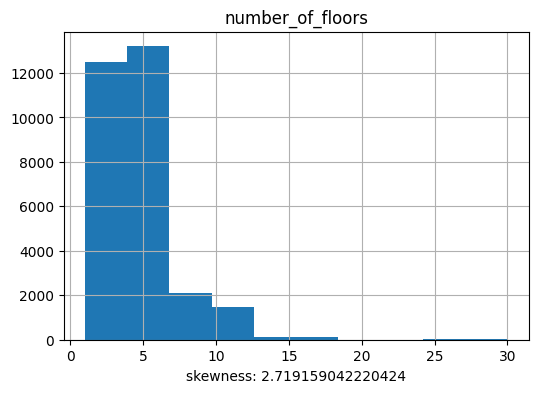

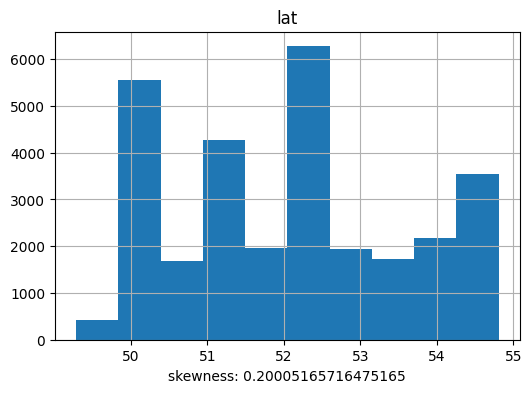

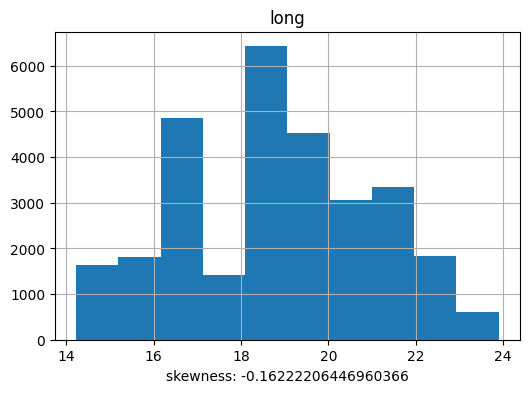

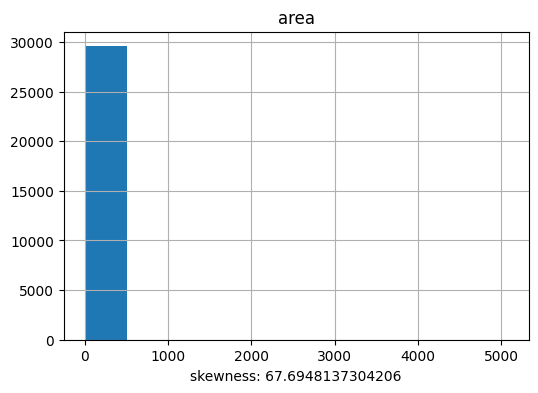

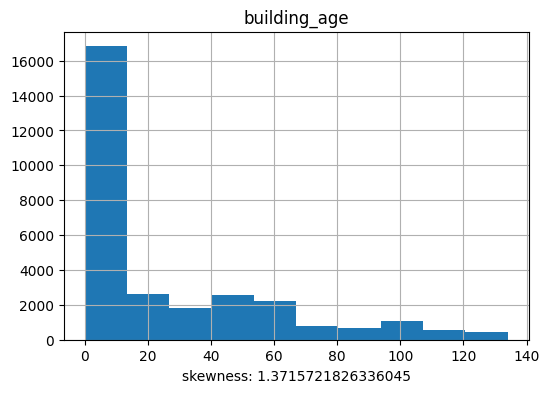

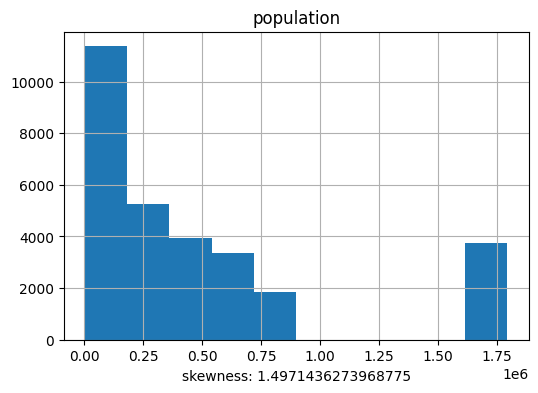

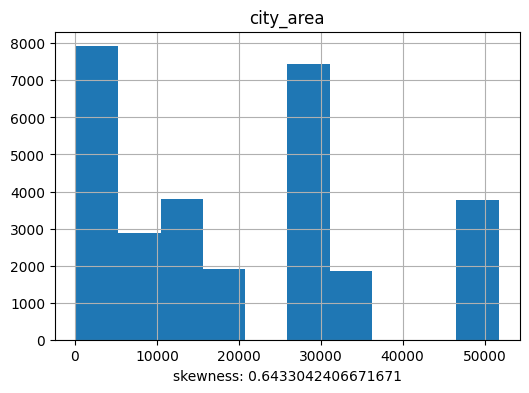

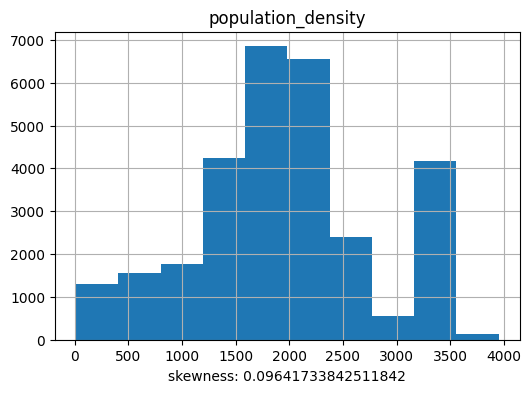

In [86]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
for column in numerical_columns:
    if all(value in [0, 1] for value in X_train[column].unique()):
        continue
    plt.figure(figsize=(6, 4))
    plt.hist(X_train[column])
    plt.title(column)
    plt.xlabel(f'skewness: {X_train[column].skew()}')
    plt.grid(True)
    plt.show()

In [87]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
non_01_columns = [column for column in numerical_columns if not all(value in [0, 1] for value in X_train[column].unique())]
skewed = [column for column in non_01_columns if np.abs(X_train[column].skew()) > 0.5]
near_normal = [column for column in non_01_columns if column not in skewed]

In [88]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29554 entries, 11178 to 15795
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               29554 non-null  int64  
 1   number_of_rooms     29554 non-null  int64  
 2   building_type       29554 non-null  object 
 3   year                29554 non-null  float64
 4   windows             29554 non-null  object 
 5   heating             29554 non-null  object 
 6   number_of_floors    29554 non-null  float64
 7   condition           29554 non-null  object 
 8   ownership           29554 non-null  object 
 9   lat                 29554 non-null  float64
 10  long                29554 non-null  float64
 11  market              29554 non-null  object 
 12  region_name         29554 non-null  object 
 13  area                29554 non-null  float64
 14  dishwasher          29554 non-null  int64  
 15  furniture           29554 non-null  int64  
 16  oven 

In [89]:
transformer = PowerTransformer()
skewed_transformed = transformer.fit_transform(X_train[skewed])
skewed_transformed_df = pd.DataFrame(skewed_transformed, index=X_train.index, columns=skewed)

/home/bugi/.pyenv/versions/data-science-pro/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/bugi/.pyenv/versions/data-science-pro/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [90]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X_train[near_normal])
scaled_df = pd.DataFrame(scaled, index=X_train.index, columns=near_normal)

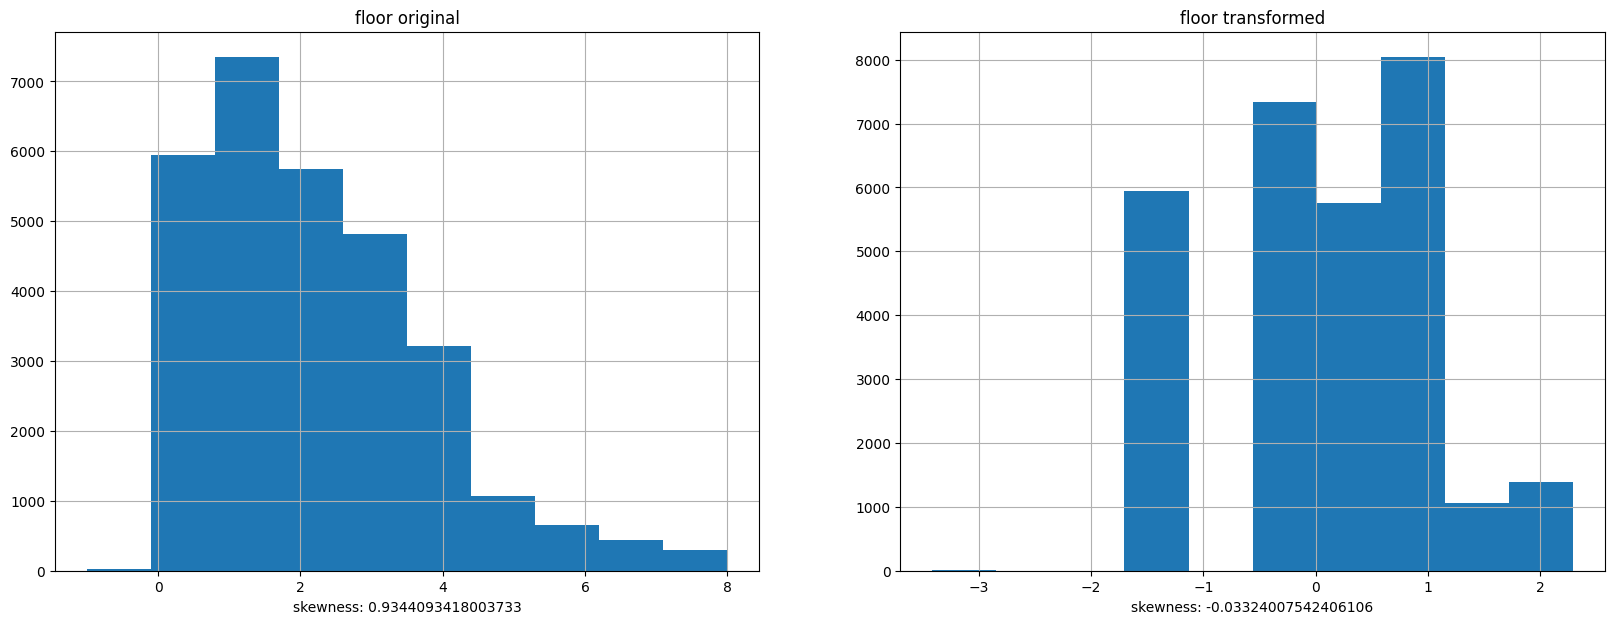

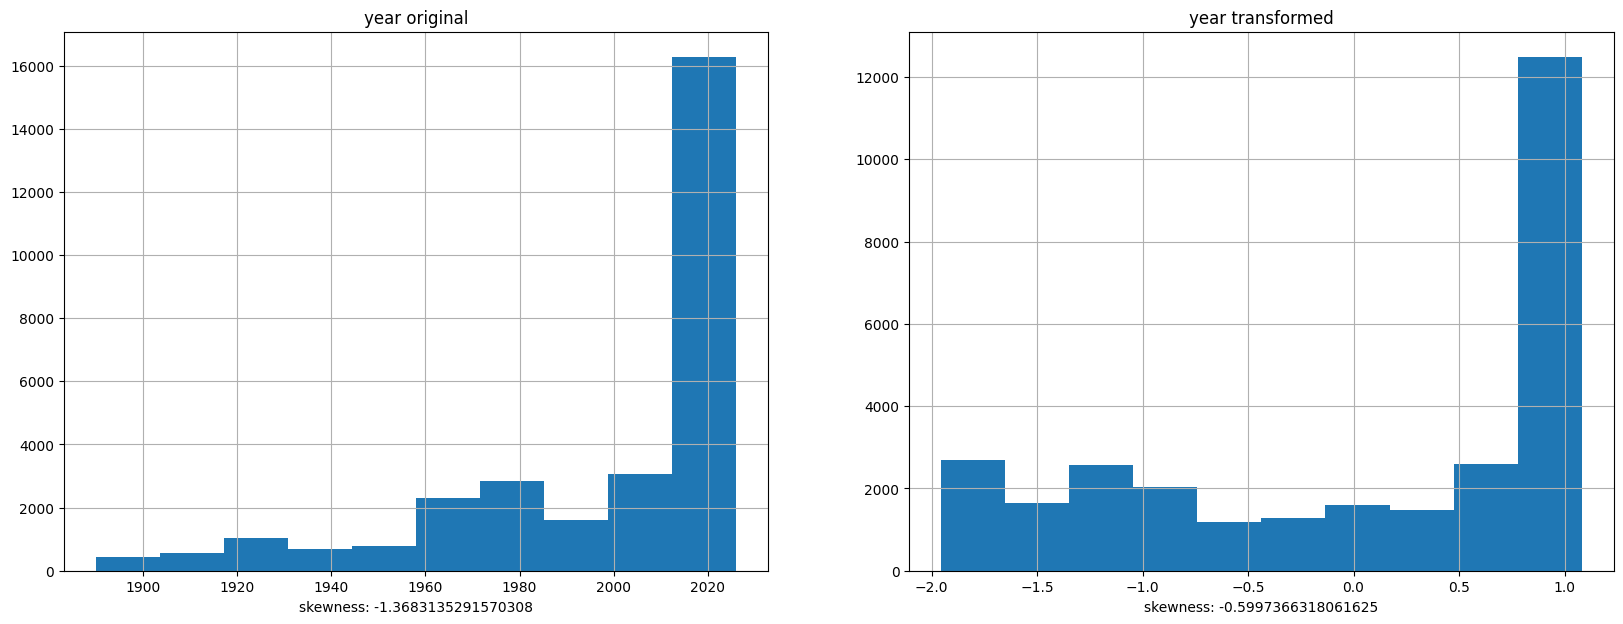

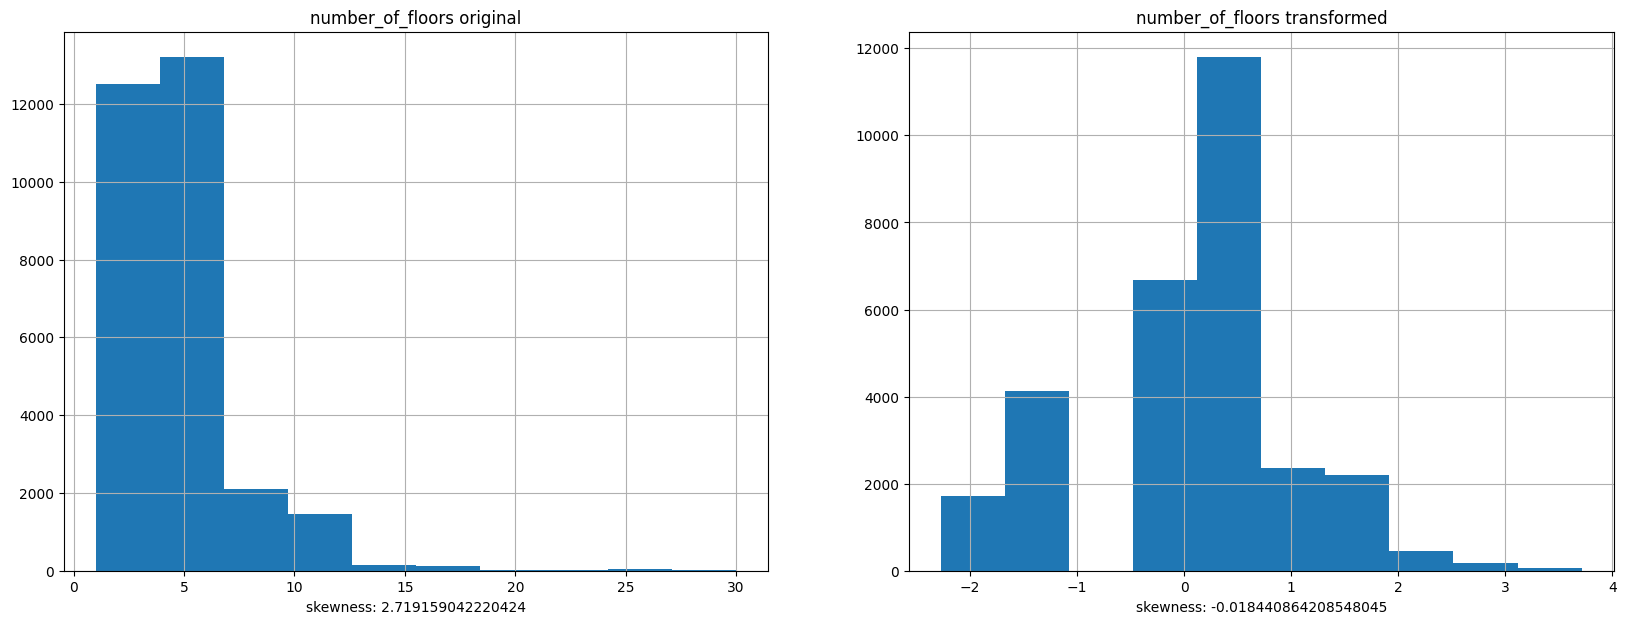

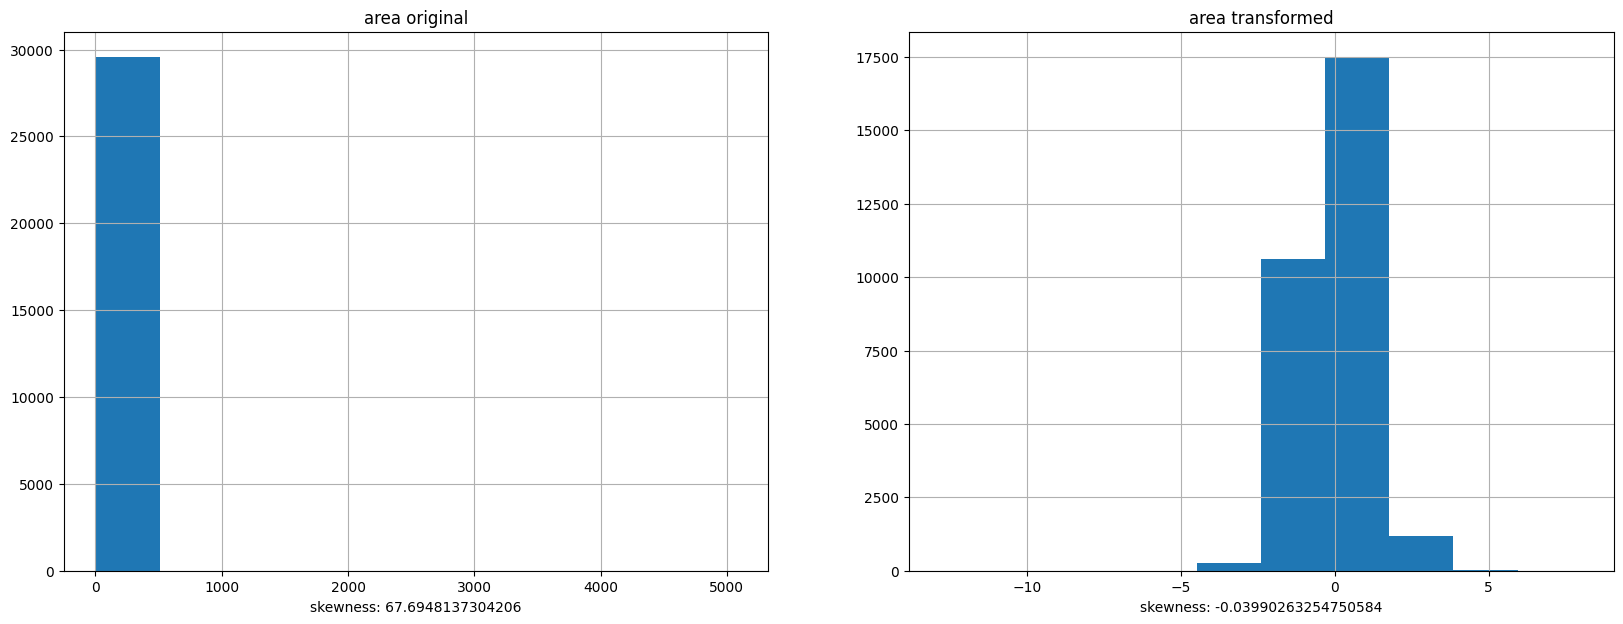

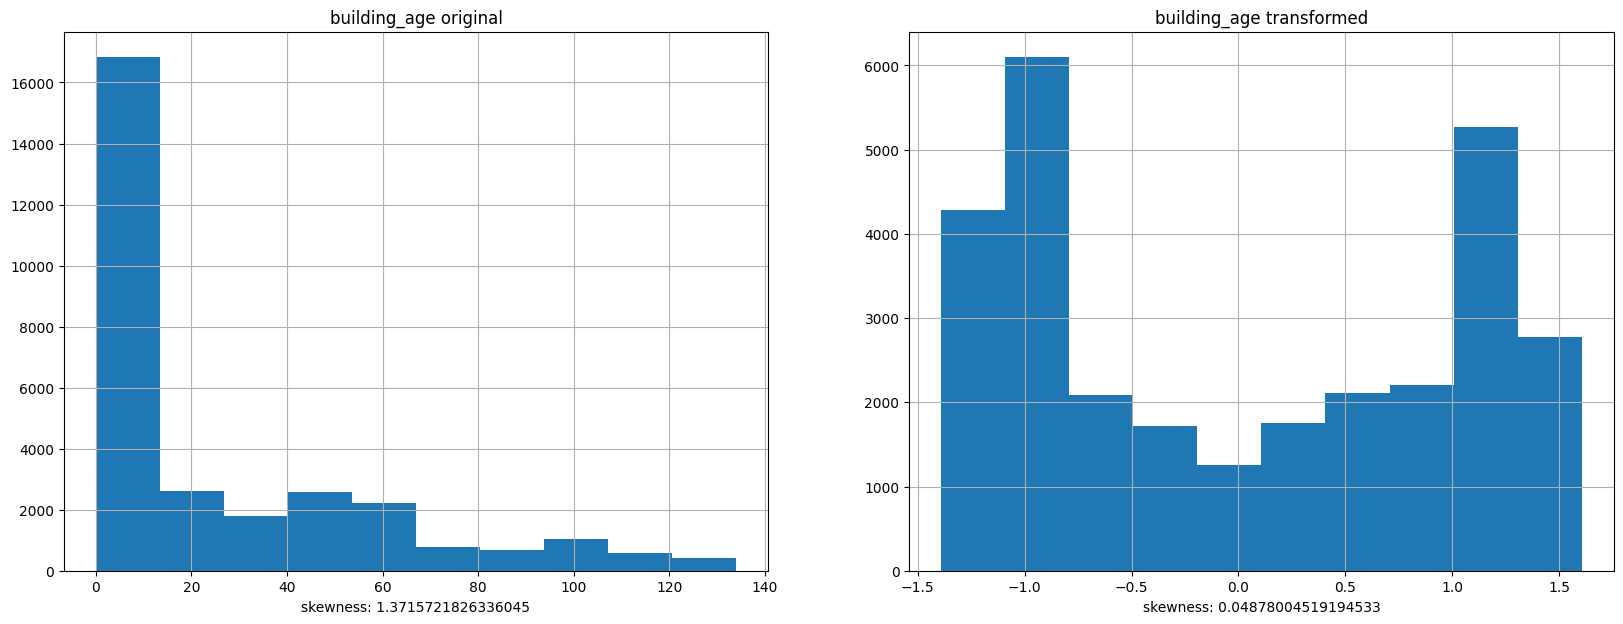

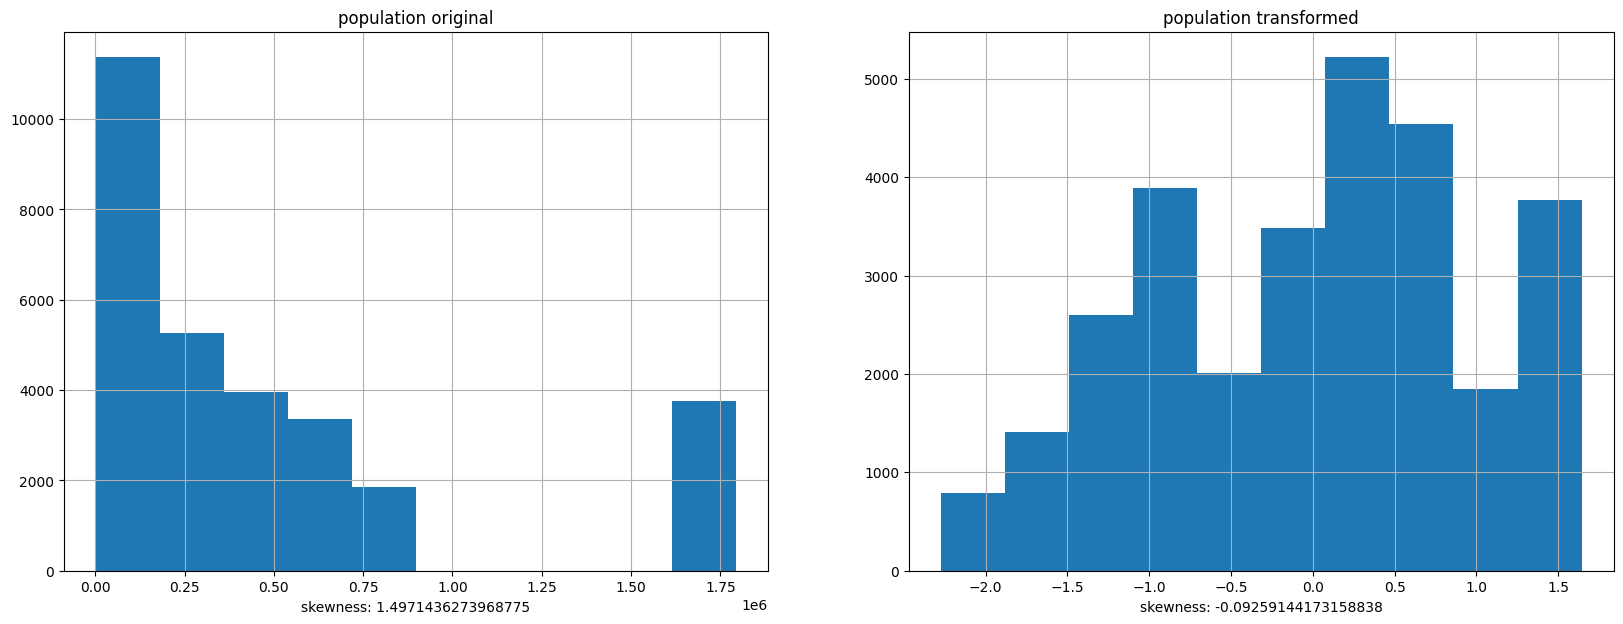

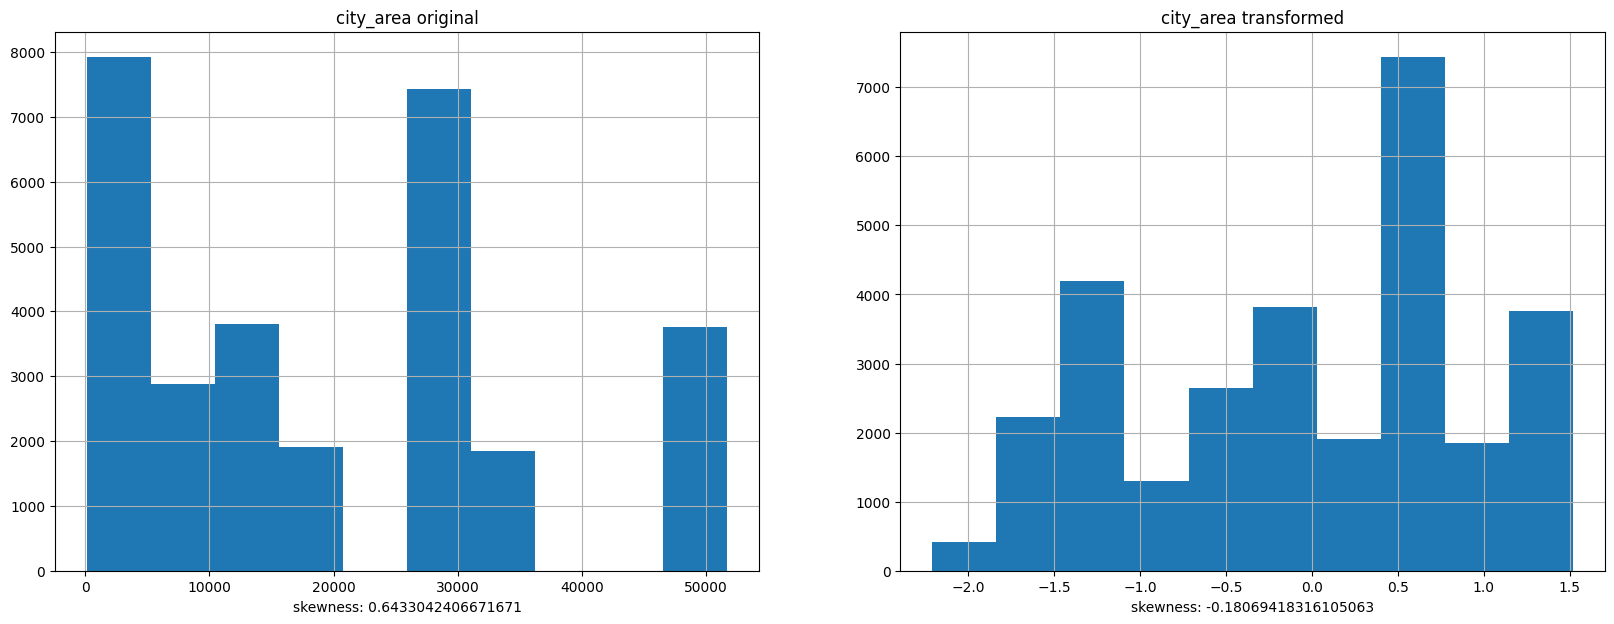

In [91]:
for column in skewed:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
    ax[0].hist(X_train[column])
    ax[0].set_title(f'{column} original')
    ax[0].set_xlabel(f'skewness: {X_train[column].skew()}')
    ax[0].grid(True)
    ax[1].hist(skewed_transformed_df[column])
    ax[1].set_title(f'{column} transformed')
    ax[1].set_xlabel(f'skewness: {skewed_transformed_df[column].skew()}')
    ax[1].grid(True)

In [92]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29554 entries, 11178 to 15795
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               29554 non-null  int64  
 1   number_of_rooms     29554 non-null  int64  
 2   building_type       29554 non-null  object 
 3   year                29554 non-null  float64
 4   windows             29554 non-null  object 
 5   heating             29554 non-null  object 
 6   number_of_floors    29554 non-null  float64
 7   condition           29554 non-null  object 
 8   ownership           29554 non-null  object 
 9   lat                 29554 non-null  float64
 10  long                29554 non-null  float64
 11  market              29554 non-null  object 
 12  region_name         29554 non-null  object 
 13  area                29554 non-null  float64
 14  dishwasher          29554 non-null  int64  
 15  furniture           29554 non-null  int64  
 16  oven 

In [93]:
X_train[skewed] = skewed_transformed_df
X_train[near_normal] = scaled_df

In [94]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29554 entries, 11178 to 15795
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               29554 non-null  float64
 1   number_of_rooms     29554 non-null  float64
 2   building_type       29554 non-null  object 
 3   year                29554 non-null  float64
 4   windows             29554 non-null  object 
 5   heating             29554 non-null  object 
 6   number_of_floors    29554 non-null  float64
 7   condition           29554 non-null  object 
 8   ownership           29554 non-null  object 
 9   lat                 29554 non-null  float64
 10  long                29554 non-null  float64
 11  market              29554 non-null  object 
 12  region_name         29554 non-null  object 
 13  area                29554 non-null  float64
 14  dishwasher          29554 non-null  int64  
 15  furniture           29554 non-null  int64  
 16  oven 

In [95]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
non_01_columns = [column for column in numerical_columns if not all(value in [0, 1] for value in X_train[column].unique())]
still_skewed = [column for column in non_01_columns if np.abs(X_train[column].skew()) > 0.5]

In [96]:
still_skewed

['year']

In [97]:
X_train.drop(columns=still_skewed, inplace=True)

<font color='orange'># consider keeping the year even if it is skewed

In [98]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29554 entries, 11178 to 15795
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor               29554 non-null  float64
 1   number_of_rooms     29554 non-null  float64
 2   building_type       29554 non-null  object 
 3   windows             29554 non-null  object 
 4   heating             29554 non-null  object 
 5   number_of_floors    29554 non-null  float64
 6   condition           29554 non-null  object 
 7   ownership           29554 non-null  object 
 8   lat                 29554 non-null  float64
 9   long                29554 non-null  float64
 10  market              29554 non-null  object 
 11  region_name         29554 non-null  object 
 12  area                29554 non-null  float64
 13  dishwasher          29554 non-null  int64  
 14  furniture           29554 non-null  int64  
 15  oven                29554 non-null  int64  
 16  stove

In [99]:
X_train.describe()

floor  number_of_rooms  number_of_floors           lat  \
count  2.955400e+04     29554.000000      2.955400e+04  29554.000000   
mean  -2.375368e-16         0.534506      1.500232e-16      0.502107   
std    1.000017e+00         0.183916      1.000017e+00      0.264226   
min   -3.415638e+00         0.000000     -2.268883e+00      0.000000   
25%   -4.700217e-01         0.400000     -3.784561e-01      0.290442   
50%    1.979827e-01         0.600000      1.678823e-01      0.521405   
75%    7.045622e-01         0.600000      5.936299e-01      0.700649   
max    2.293144e+00         1.000000      3.711878e+00      1.000000   

               long          area    dishwasher     furniture          oven  \
count  29554.000000  2.955400e+04  29554.000000  29554.000000  29554.000000   
mean       0.480611 -2.334256e-15      0.161095      0.320972      0.205522   
std        0.222002  1.000017e+00      0.367625      0.466858      0.404089   
min        0.000000 -1.280939e+01      0.000000      0.000000      0.000000   
25%        0.291007 -6.146310e-01      0.000000      0.000000      0.000000   
50%        0.485722  1.753863e-02      0.000000      0.000000      0.000000   
75%        0.686920  6.115357e-01      0.000000      1.000000      0.000000   
max        1.000000  8.022566e+00      1.000000      1.000000      1.000000   

              stove        fridge  washing_machine  air_conditioning  \
count  29554.000000  29554.000000     29554.000000      29554.000000   
mean       0.219327      0.213101         0.154057          0.074948   
std        0.413798      0.409506         0.361009          0.263311   
min        0.000000      0.000000         0.000000          0.000000   
25%        0.000000      0.000000         0.000000          0.000000   
50%        0.000000      0.000000         0.000000          0.000000   
75%        0.000000      0.000000         0.000000          0.000000   
max        1.000000      1.000000         1.000000          1.000000   

                 tv       balcony      basement        garage        garden  \
count  29554.000000  29554.000000  29554.000000  29554.000000  29554.000000   
mean       0.074034      0.624856      0.376734      0.561819      0.128511   
std        0.261831      0.484168      0.484576      0.496172      0.334663   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      1.000000      0.000000   
75%        0.000000      1.000000      1.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            terrace   usable_room      INTERNET          LIFT    ENTRYPHONE  \
count  29554.000000  29554.000000  29554.000000  29554.000000  29554.000000   
mean       0.151790      0.225824      0.549976      0.510049      0.595994   
std        0.358823      0.418131      0.497505      0.499907      0.490707   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000      1.000000      1.000000   
75%        0.000000      0.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              ALARM   CLOSED_AREA  ROLLER_SHUTTERS  ANTI_BURGLARY_DOOR  \
count  29554.000000  29554.000000     29554.000000        29554.000000   
mean       0.079482      0.230020         0.044732            0.304493   
std        0.270494      0.420852         0.206718            0.460200   
min        0.000000      0.000000         0.000000            0.000000   
25%        0.000000      0.000000         0.000000            0.000000   
50%        0.000000      0.000000         0.000000            0.000000   
75%        0.000000      0.000000         0.000000            

## One hot encoding

In [100]:
X_train_categorical = X_train.select_dtypes(include="object")
X_train_categorical.nunique()

building_type     4
windows           2
heating           3
condition         2
ownership         2
market            2
region_name      16
dtype: int64

In [101]:
custom_drop_features = ['heating', 'condition', 'ownership', 'building_type']
categories_to_drop = ['OTHER', 'TO_COMPLETION', 'LIMITED_OWNERSHIP', 'OTHER']

ohe = OneHotEncoder(drop=categories_to_drop, sparse_output=False, dtype=int)
ohe_custom_drop_df = pd.DataFrame(ohe.fit_transform(X_train_categorical[custom_drop_features]), columns=ohe.get_feature_names_out(), index=X_train.index)

In [102]:
features = ['windows', 'market', 'region_name']

ohe = OneHotEncoder(drop='first', sparse_output=False, dtype=int)
ohe_features_df = pd.DataFrame(ohe.fit_transform(X_train_categorical[features]), columns=ohe.get_feature_names_out(), index=X_train.index)

In [103]:
X_train = pd.concat([
    X_train.drop(columns=custom_drop_features + features), 
    ohe_custom_drop_df,
    ohe_features_df
], axis=1)

In [104]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29554 entries, 11178 to 15795
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   floor                            29554 non-null  float64
 1   number_of_rooms                  29554 non-null  float64
 2   number_of_floors                 29554 non-null  float64
 3   lat                              29554 non-null  float64
 4   long                             29554 non-null  float64
 5   area                             29554 non-null  float64
 6   dishwasher                       29554 non-null  int64  
 7   furniture                        29554 non-null  int64  
 8   oven                             29554 non-null  int64  
 9   stove                            29554 non-null  int64  
 10  fridge                           29554 non-null  int64  
 11  washing_machine                  29554 non-null  int64  
 12  air_conditioning   

## Feature selection

### Correalation

- allign X_train and y_train indexes

In [105]:
type(y_train)

pandas.core.series.Series

In [106]:
common_indices = X_train.index.intersection(y_train.index)
y_train = y_train.loc[common_indices]

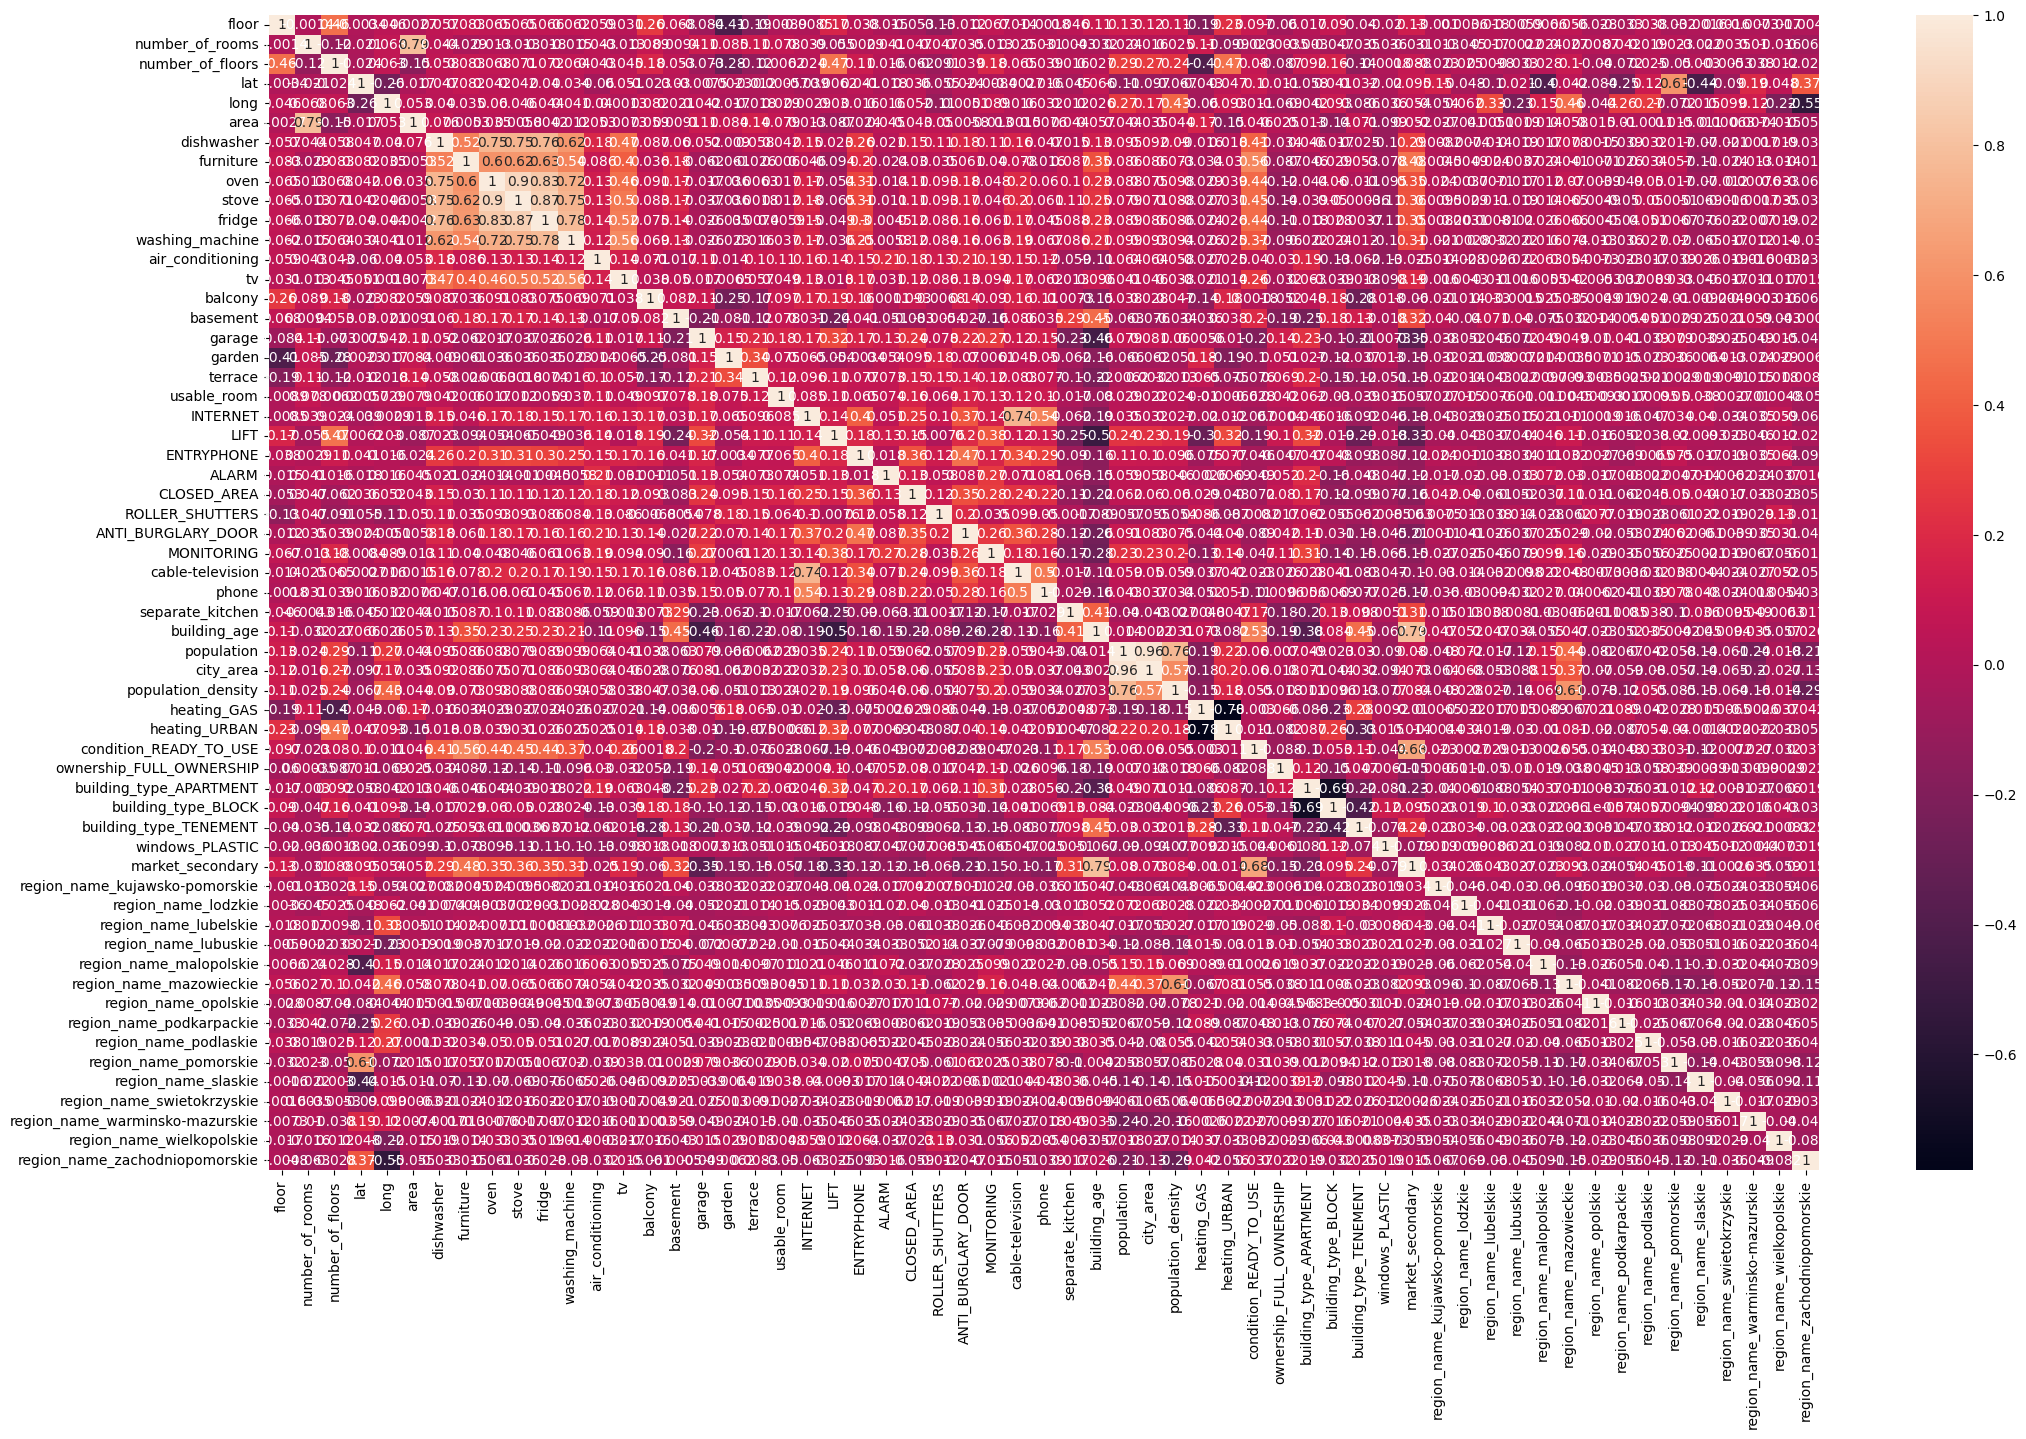

In [107]:
plt.figure(figsize=(25,15))
sns.heatmap(X_train.corr(), annot=True);

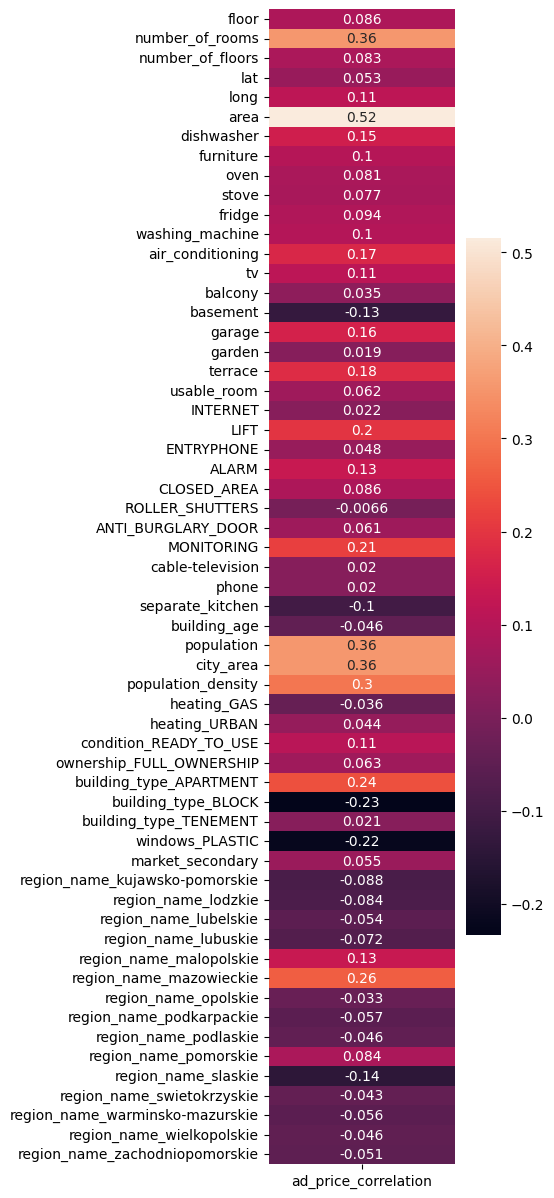

In [108]:
correlations = X_train.corrwith(y_train)
corr_df = correlations.to_frame(name='ad_price_correlation')

plt.figure(figsize=(3, 15))
sns.heatmap(corr_df, annot=True);

In [109]:
(x := correlations.abs()).sort_values(ascending=False)[x > 0.5].index

Index(['area'], dtype='object')

In [110]:
(x := correlations.abs()).sort_values(ascending=False)[x > 0.25].index

Index(['area', 'number_of_rooms', 'population', 'city_area',
       'population_density', 'region_name_mazowieckie'],
      dtype='object')

In [111]:
selected_corr = (x := correlations.abs()).sort_values(ascending=False)[x > 0.2].index.to_list()

In [112]:
selected_corr

['area',
 'number_of_rooms',
 'population',
 'city_area',
 'population_density',
 'region_name_mazowieckie',
 'building_type_APARTMENT',
 'building_type_BLOCK',
 'windows_PLASTIC',
 'MONITORING']

### SequentialFeatureSelector

In [113]:
# model = LinearRegression()
# n_features_to_select = 20

# sfs = SequentialFeatureSelector(
#     model, direction='forward', scoring='r2', n_features_to_select=n_features_to_select, n_jobs=-1)
# sfs.fit(X_train, y_train)
# choices = sfs.get_support()
# selected_forward = [
#     feature for feature, is_selected in zip(X_train.columns, choices) if is_selected
# ]

In [114]:
# model = LinearRegression()
# n_features_to_select = 20

# sfs = SequentialFeatureSelector(
#     model, direction='backward', scoring='r2', n_features_to_select=n_features_to_select, n_jobs=-1)
# sfs.fit(X_train, y_train)
# choices = sfs.get_support()
# selected_backward = [
#     feature for feature, is_selected in zip(X_train.columns, choices) if is_selected
# ]

In [115]:
# selected_features = list((set(selected_corr)).union(set(selected_forward).intersection(selected_backward)))

In [116]:
selected_features = ['terrace',
 'MONITORING',
 'building_type_TENEMENT',
 'basement',
 'building_type_APARTMENT',
 'region_name_malopolskie',
 'condition_READY_TO_USE',
 'windows_PLASTIC',
 'population',
 'area',
 'building_type_BLOCK',
 'population_density',
 'region_name_lodzkie',
 'number_of_rooms',
 'LIFT',
 'region_name_mazowieckie',
 'air_conditioning',
 'city_area']
selected_features

['terrace',
 'MONITORING',
 'building_type_TENEMENT',
 'basement',
 'building_type_APARTMENT',
 'region_name_malopolskie',
 'condition_READY_TO_USE',
 'windows_PLASTIC',
 'population',
 'area',
 'building_type_BLOCK',
 'population_density',
 'region_name_lodzkie',
 'number_of_rooms',
 'LIFT',
 'region_name_mazowieckie',
 'air_conditioning',
 'city_area']

- applying the same transformations to the test set
  - scaling
  - removal of the year column
  - one hot encoding

In [117]:
# scaling
skewed_transformed = transformer.fit_transform(X_test[skewed])
skewed_transformed_df = pd.DataFrame(skewed_transformed, index=X_test.index, columns=skewed)

scaled = scaler.fit_transform(X_test[near_normal])
scaled_df = pd.DataFrame(scaled, index=X_test.index, columns=near_normal)

X_test[skewed] = skewed_transformed_df
X_test[near_normal] = scaled_df

# removal of the year column
X_test.drop(columns=['year'], inplace=True)

# one hot encoding
custom_drop_features = ['heating', 'condition', 'ownership', 'building_type']
categories_to_drop = ['OTHER', 'TO_COMPLETION', 'LIMITED_OWNERSHIP', 'OTHER']

ohe = OneHotEncoder(drop=categories_to_drop, sparse_output=False, dtype=int)
ohe_custom_drop_df = pd.DataFrame(ohe.fit_transform(X_test[custom_drop_features]), columns=ohe.get_feature_names_out(), index=X_test.index)

features = ['windows', 'market', 'region_name']

ohe = OneHotEncoder(drop='first', sparse_output=False, dtype=int)
ohe_features_df = pd.DataFrame(ohe.fit_transform(X_test[features]), columns=ohe.get_feature_names_out(), index=X_test.index)

X_test = pd.concat([
    X_test.drop(columns=custom_drop_features + features), 
    ohe_custom_drop_df,
    ohe_features_df
], axis=1)

# allign X_test and y_test indexes
common_indices = X_test.index.intersection(y_test.index)
y_test = y_test.loc[common_indices]

/home/bugi/.pyenv/versions/data-science-pro/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/bugi/.pyenv/versions/data-science-pro/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [118]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7687 entries, 17691 to 25185
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   floor                            7687 non-null   float64
 1   number_of_rooms                  7687 non-null   float64
 2   number_of_floors                 7687 non-null   float64
 3   lat                              7687 non-null   float64
 4   long                             7687 non-null   float64
 5   area                             7687 non-null   float64
 6   dishwasher                       7687 non-null   int64  
 7   furniture                        7687 non-null   int64  
 8   oven                             7687 non-null   int64  
 9   stove                            7687 non-null   int64  
 10  fridge                           7687 non-null   int64  
 11  washing_machine                  7687 non-null   int64  
 12  air_conditioning    

# Model Building & Evaluation

In [119]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29554 entries, 11178 to 15795
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   floor                            29554 non-null  float64
 1   number_of_rooms                  29554 non-null  float64
 2   number_of_floors                 29554 non-null  float64
 3   lat                              29554 non-null  float64
 4   long                             29554 non-null  float64
 5   area                             29554 non-null  float64
 6   dishwasher                       29554 non-null  int64  
 7   furniture                        29554 non-null  int64  
 8   oven                             29554 non-null  int64  
 9   stove                            29554 non-null  int64  
 10  fridge                           29554 non-null  int64  
 11  washing_machine                  29554 non-null  int64  
 12  air_conditioning   

In [120]:
X_train[selected_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 29554 entries, 11178 to 15795
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   terrace                  29554 non-null  int64  
 1   MONITORING               29554 non-null  int64  
 2   building_type_TENEMENT   29554 non-null  int64  
 3   basement                 29554 non-null  int64  
 4   building_type_APARTMENT  29554 non-null  int64  
 5   region_name_malopolskie  29554 non-null  int64  
 6   condition_READY_TO_USE   29554 non-null  int64  
 7   windows_PLASTIC          29554 non-null  int64  
 8   population               29554 non-null  float64
 9   area                     29554 non-null  float64
 10  building_type_BLOCK      29554 non-null  int64  
 11  population_density       29554 non-null  float64
 12  region_name_lodzkie      29554 non-null  int64  
 13  number_of_rooms          29554 non-null  float64
 14  LIFT                   

In [121]:
def get_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    return dict(mae=mae, mape=mape, r2=r2)


def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    print('Train set:', get_metrics(y_train, y_pred_train))
    y_pred = model.predict(X_test)
    print('Test set: ', get_metrics(y_test, y_pred))


def perform_gridsearch(model, param_grid, cv=5):
    start_time = time.time()
    optimizer = GridSearchCV(model, param_grid, cv=cv)
    optimizer.fit(X_train, y_train)
    best_estimator = optimizer.best_estimator_
    elapsed_time_sec = time.time() - start_time
    print(f'{round(elapsed_time_sec, 2)} sec')
    for k, v in optimizer.best_params_.items():
        print(f'{k}: {v}')
    return best_estimator

In [122]:
X_train_selected, X_test_selected = X_train[selected_features], X_test[selected_features]

### LinearRegression

- training with all features

In [123]:
model = LinearRegression()
model.fit(X_train, y_train)
evaluate_model(model, X_train, X_test, y_train, y_test)

Train set: {'mae': 194243.438377791, 'mape': 34.15678806074456, 'r2': 0.5379504577953785}
Test set:  {'mae': 227201.9598377544, 'mape': 38.170750678744945, 'r2': 0.42143096373852296}


- training with selected features

In [124]:
model = LinearRegression()
model.fit(X_train_selected, y_train)
evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)

Train set: {'mae': 202481.67613555488, 'mape': 35.108636241789114, 'r2': 0.5075172158198242}
Test set:  {'mae': 233563.52919401685, 'mape': 39.015464872685634, 'r2': 0.39895352861035405}


### ElasticNet

- training with all features

In [125]:
model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
model.fit(X_train, y_train)
evaluate_model(model, X_train, X_test, y_train, y_test)

Train set: {'mae': 192768.72423579797, 'mape': 30.454698606280733, 'r2': 0.43618471987565866}
Test set:  {'mae': 200283.72857460426, 'mape': 29.65716688968702, 'r2': 0.3406967677346683}


- training with selected features

In [126]:
model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
model.fit(X_train_selected, y_train)
evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)

Train set: {'mae': 199859.13169990625, 'mape': 32.13446390314678, 'r2': 0.41803147783798844}
Test set:  {'mae': 208206.72941727654, 'mape': 31.411091398644718, 'r2': 0.3264088233225033}


- grid search with all features

In [127]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'selection': ['cyclic', 'random']
}
best_estimator = perform_gridsearch(ElasticNet(), param_grid)
evaluate_model(best_estimator, X_train, X_test, y_train, y_test)

29.37 sec
alpha: 0.1
l1_ratio: 0.9
selection: random
Train set: {'mae': 193287.43265270247, 'mape': 33.484513085946155, 'r2': 0.5315437829666843}
Test set:  {'mae': 213100.8115979202, 'mape': 35.154485989322175, 'r2': 0.42257539497366925}


### Ridge

- training with all features

In [128]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
evaluate_model(model, X_train, X_test, y_train, y_test)

Train set: {'mae': 194199.23268866047, 'mape': 34.13772672302252, 'r2': 0.537944711889196}
Test set:  {'mae': 227072.53411853398, 'mape': 38.1394370662475, 'r2': 0.421456896570536}


- training with selected features

In [129]:
model = Ridge(alpha=1.0)
model.fit(X_train_selected, y_train)
evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)

Train set: {'mae': 202458.34539264257, 'mape': 35.10106062477603, 'r2': 0.5075164156666676}
Test set:  {'mae': 233460.92099802502, 'mape': 38.99292892637898, 'r2': 0.3990032577718011}


- grid search with all features

In [130]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
best_estimator = perform_gridsearch(Ridge(), param_grid)
evaluate_model(best_estimator, X_train, X_test, y_train, y_test)

24.03 sec
alpha: 0.1
solver: auto
Train set: {'mae': 194238.54195142933, 'mape': 34.15472209187257, 'r2': 0.5379503947538298}
Test set:  {'mae': 227188.5947971785, 'mape': 38.16746807681209, 'r2': 0.4214337960444926}


### Lasso

- training with all features

In [131]:
model = Lasso(alpha=0.1, max_iter=10000)
model.fit(X_train, y_train)
evaluate_model(model, X_train, X_test, y_train, y_test)

Train set: {'mae': 194242.8948303015, 'mape': 34.156548660481064, 'r2': 0.5379504570064739}
Test set:  {'mae': 227200.51206255332, 'mape': 38.1703912744992, 'r2': 0.421431199792042}


- training with selected features

In [132]:
model = Lasso(alpha=0.1, max_iter=10000)
model.fit(X_train_selected, y_train)
evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)

Train set: {'mae': 202481.40286087975, 'mape': 35.108553797064694, 'r2': 0.5075172157827124}
Test set:  {'mae': 233562.39520137355, 'mape': 39.015216788642135, 'r2': 0.39895404925184275}


- grid search with all features

In [133]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'selection': ['cyclic', 'random']
}
best_estimator = perform_gridsearch(Lasso(max_iter=10000), param_grid)
evaluate_model(best_estimator, X_train, X_test, y_train, y_test)

62.54 sec
alpha: 1.0
selection: cyclic
Train set: {'mae': 194238.0268805847, 'mape': 34.154398998660405, 'r2': 0.5379503789056653}
Test set:  {'mae': 227187.58878845707, 'mape': 38.167182143424874, 'r2': 0.42143327351622095}


### RandomForestRegressor

- training with all features

In [134]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
evaluate_model(model, X_train, X_test, y_train, y_test)

Train set: {'mae': 32195.055593522586, 'mape': 4.535037854043448, 'r2': 0.9800183127202854}
Test set:  {'mae': 108932.13294186271, 'mape': 14.57328424562722, 'r2': 0.7636492738700247}


- training with selected features

In [135]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)
evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)

Train set: {'mae': 41172.786521579204, 'mape': 5.9006386069261385, 'r2': 0.9713765594234831}
Test set:  {'mae': 143450.84389262344, 'mape': 19.642226675233225, 'r2': 0.6556158368145111}


- randomized search with all features

In [139]:
start_time = time.time()

model = RandomForestRegressor(random_state=42)

distributions = {
    'n_estimators': [50, 100, 200],       
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],
}

optimizer = RandomizedSearchCV(
    model, 
    distributions, 
    n_iter=40,
    n_jobs=-1,
    cv=5
)
optimizer.fit(X_train, y_train)

elapsed_time_sec = time.time() - start_time
print(f'{round(elapsed_time_sec, 2)} sec')

405.68 sec


In [140]:
best_estimator = optimizer.best_estimator_
for k, v in optimizer.best_params_.items():
    print(f'{k}: {v}')

evaluate_model(best_estimator, X_train, X_test, y_train, y_test)

n_estimators: 100
min_samples_split: 2
min_samples_leaf: 2
max_depth: 30
Train set: {'mae': 39150.251061078525, 'mape': 5.498038020685037, 'r2': 0.9676117494261924}
Test set:  {'mae': 105593.89012046483, 'mape': 13.996140105497162, 'r2': 0.7680284424542589}


### XGBRegressor

- training with all features

In [141]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)
evaluate_model(model, X_train, X_test, y_train, y_test)

Train set: {'mae': 61255.08864208767, 'mape': 9.976846448023046, 'r2': 0.9684171747226574}
Test set:  {'mae': 108447.31290551418, 'mape': 14.505372646986798, 'r2': 0.7790243500385483}


- training with selected features

In [142]:
model = XGBRegressor(random_state=42)
model.fit(X_train_selected, y_train)
evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)

Train set: {'mae': 89833.41015524548, 'mape': 13.747316932457759, 'r2': 0.9221952969411229}
Test set:  {'mae': 144307.62615454663, 'mape': 19.286244532525753, 'r2': 0.6337816346926038}


- randomized search with all features

In [143]:
start_time = time.time()

model = XGBRegressor(random_state=42)

distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 9),
    'min_child_weight': uniform(1, 7),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'alpha': uniform(0, 4),
    'lambda': uniform(0, 10)
}

optimizer = RandomizedSearchCV(
    model, 
    distributions, 
    n_iter=100,
    n_jobs=-1,
    cv=5
)
optimizer.fit(X_train, y_train)

elapsed_time_sec = time.time() - start_time
print(f'{round(elapsed_time_sec, 2)} sec')

364.43 sec


In [144]:
best_estimator = optimizer.best_estimator_
for k, v in optimizer.best_params_.items():
    print(f'{k}: {v}')

evaluate_model(best_estimator, X_train, X_test, y_train, y_test)

alpha: 3.2892043952829346
colsample_bytree: 0.7469880237029634
gamma: 0.4314022023797172
lambda: 1.304358093395559
learning_rate: 0.10098915055644084
max_depth: 8
min_child_weight: 3.6876409186310126
n_estimators: 300
subsample: 0.7777835333568324
Train set: {'mae': 42632.213324867196, 'mape': 7.228648252635336, 'r2': 0.9852593400678267}
Test set:  {'mae': 102076.03521062345, 'mape': 13.228575079711497, 'r2': 0.7658630200478281}
